# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import time

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
#load only some rows of the dataset to see how data is in our files = time.time()
s = time.time()
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
e = time.time()
print("Pandas Loading Time = {}".format(e-s))
#customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';') #, nrows = 5)
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',  sep = ';')

Pandas Loading Time = 7.228112459182739


In [3]:
#create a dictionary of feature datatypes
feat_dtype = {d['attribute']:d['type'] for d in feat_info.iloc[:, [0,2]].to_dict(orient='records')};

In [4]:
#import with Dask
s = time.time()
azdias_dd = dd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
e = time.time()
print("Dask Loading Time = {}".format(e-s))

Dask Loading Time = 0.034105777740478516


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
#We will be working on a copy of our original dataframe for security reasons
az = azdias.copy()

In [7]:
feat_info.columns

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')

In [8]:
#check column index to be treated differently with NaN's
for i in list(feat_info.missing_or_unknown.unique()):
    print('Columns with {} as Nans: {}'.format(i, tuple(feat_info[feat_info.missing_or_unknown == i].index)))

Columns with [-1,0] as Nans: (0, 2, 14, 21, 22, 40, 46, 48, 49, 52, 64, 65, 70, 73, 79, 83)
Columns with [-1,0,9] as Nans: (1,)
Columns with [0] as Nans: (3, 11, 15, 16, 17, 18, 19, 20, 23, 43, 50, 54)
Columns with [-1] as Nans: (4, 5, 6, 7, 8, 9, 10, 38, 39, 41, 47, 55, 56, 60, 61, 62, 63, 66, 67, 68, 75, 76, 77, 78, 80, 81)
Columns with [] as Nans: (12, 13, 44, 45, 51, 53, 69, 71, 72, 74)
Columns with [-1,9] as Nans: (24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 42, 82, 84)
Columns with [-1,X] as Nans: (57,)
Columns with [XX] as Nans: (58,)
Columns with [-1,XX] as Nans: (59,)


In [9]:
#check different values of missing categories from feat_info 
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

As we can observe at the `Data_Dictionary.md` file these are all possible Nan values, including the ones we have had initialy
 `'[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]','[XX]', '[-1,XX]'`. We will create a function to elaborate those.

In [10]:
# Identify missing or unknown data values and convert them to NaNs. 
def replace_nans(df):
    ''' This is a function that replaces empty values with np.nan values in a DataFrame'''
    for col in feat_info[feat_info.missing_or_unknown == '[-1,0]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan).replace('0', np.nan)
        print('Replaced [-1,0] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1,0,9]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan).replace('0', np.nan).replace('9', np.nan)
        print('Replaced [-1,0,9] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[0]'].attribute:
        df[col] = df[col].astype('str').replace('0', np.nan)
        print('Replaced [0] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan)
        print('Replaced [-1] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[]'].attribute:
        df[col] = df[col].astype('str').replace(r'^\s*$', np.nan, regex=True)
        print('Replaced [] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1,9]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan).replace('9', np.nan)
        print('Replaced [-1,9] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1,X]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan).replace('X', np.nan)
        print('Replaced [-1,X] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[XX]'].attribute:
        df[col] = df[col].astype('str').replace('XX', np.nan)
        print('Replaced [XX] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1,XX]'].attribute:
        df[col] = df[col].astype('str').replace('-1,XX', np.nan)
        print('Replaced [-1,XX] values in {} column'.format(col))
    
    
    #when we convert numeric variables to strings np.nan values are converted to the string 'nan'
    #with this loop we homogenize all nan values
    for df_col in df.columns:
        df[df_col] = df[df_col].astype('str').replace('nan',\
                                                      np.nan).replace('NaN', np.nan).replace(r'^\s*$', np.nan, regex=True)
    print('Replacing {}, {} or {} strings'.format('nan', 'NaN', 'empty spaces'))
    
    return df

In [11]:
s = time.time()
az = replace_nans(az)
e = time.time()

print('Running time: {} minutes'.format(round((e-s))/60, 2) )

Replaced [-1,0] values in AGER_TYP column
Replaced [-1,0] values in ANREDE_KZ column
Replaced [-1,0] values in HEALTH_TYP column
Replaced [-1,0] values in NATIONALITAET_KZ column
Replaced [-1,0] values in PRAEGENDE_JUGENDJAHRE column
Replaced [-1,0] values in TITEL_KZ column
Replaced [-1,0] values in HH_EINKOMMEN_SCORE column
Replaced [-1,0] values in W_KEIT_KIND_HH column
Replaced [-1,0] values in WOHNDAUER_2008 column
Replaced [-1,0] values in GEBAEUDETYP column
Replaced [-1,0] values in KBA05_BAUMAX column
Replaced [-1,0] values in KBA05_GBZ column
Replaced [-1,0] values in KKK column
Replaced [-1,0] values in REGIOTYP column
Replaced [-1,0] values in PLZ8_BAUMAX column
Replaced [-1,0] values in ORTSGR_KLS9 column
Replaced [-1,0,9] values in ALTERSKATEGORIE_GROB column
Replaced [0] values in CJT_GESAMTTYP column
Replaced [0] values in GEBURTSJAHR column
Replaced [0] values in LP_LEBENSPHASE_FEIN column
Replaced [0] values in LP_LEBENSPHASE_GROB column
Replaced [0] values in LP_FAMIL

In [12]:
#check finally how many missing values we have!
s = time.time()
for col in enumerate(az.columns):
    null_cols = az[col[1]].isnull().values.sum()
    print('{}. {} {}'.format(col[0], null_cols, col[1]))
e = time.time()
print('Running time: {} minutes'.format(round((e-s))/60, 2) )

0. 685843 AGER_TYP
1. 2881 ALTERSKATEGORIE_GROB
2. 0 ANREDE_KZ
3. 4854 CJT_GESAMTTYP
4. 0 FINANZ_MINIMALIST
5. 0 FINANZ_SPARER
6. 0 FINANZ_VORSORGER
7. 0 FINANZ_ANLEGER
8. 0 FINANZ_UNAUFFAELLIGER
9. 0 FINANZ_HAUSBAUER
10. 0 FINANZTYP
11. 392318 GEBURTSJAHR
12. 4854 GFK_URLAUBERTYP
13. 0 GREEN_AVANTGARDE
14. 111196 HEALTH_TYP
15. 4854 LP_LEBENSPHASE_FEIN
16. 4854 LP_LEBENSPHASE_GROB
17. 4854 LP_FAMILIE_FEIN
18. 4854 LP_FAMILIE_GROB
19. 4854 LP_STATUS_FEIN
20. 4854 LP_STATUS_GROB
21. 108315 NATIONALITAET_KZ
22. 108164 PRAEGENDE_JUGENDJAHRE
23. 4854 RETOURTYP_BK_S
24. 0 SEMIO_SOZ
25. 0 SEMIO_FAM
26. 0 SEMIO_REL
27. 0 SEMIO_MAT
28. 0 SEMIO_VERT
29. 0 SEMIO_LUST
30. 0 SEMIO_ERL
31. 0 SEMIO_KULT
32. 0 SEMIO_RAT
33. 0 SEMIO_KRIT
34. 0 SEMIO_DOM
35. 0 SEMIO_KAEM
36. 0 SEMIO_PFLICHT
37. 0 SEMIO_TRADV
38. 111196 SHOPPER_TYP
39. 73499 SOHO_KZ
40. 73499 TITEL_KZ
41. 111196 VERS_TYP
42. 0 ZABEOTYP
43. 73499 ALTER_HH
44. 73499 ANZ_PERSONEN
45. 73499 ANZ_TITEL
46. 18348 HH_EINKOMMEN_SCORE
47. 584612 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
az_nan_cols = [column for column in az.columns if az[column].isnull().sum() > 0] #NanN list in azdias
#customers_nan_cols = [column for column in customers.columns if customers[column].isnull().sum() > 0] #NaN list in customers

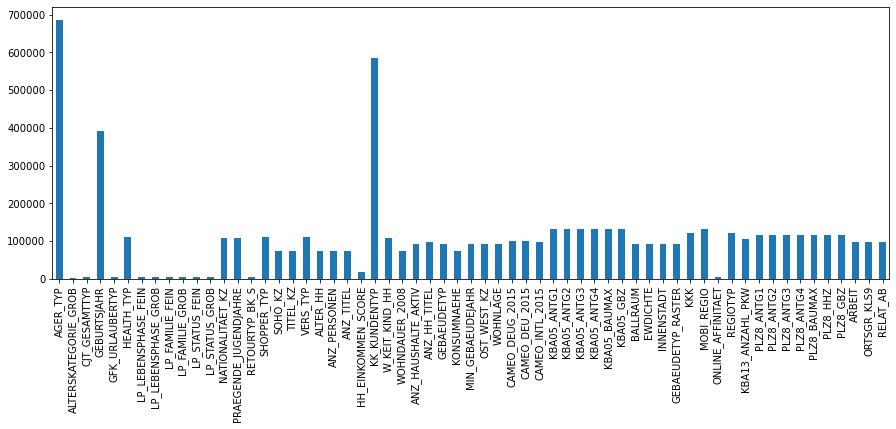

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize = [15, 5])
az.loc[:, az_nan_cols].isnull().sum().plot(kind = 'bar');

In [15]:
col_missing_percentage = {}
def col_percentage_nulls(df):
    for col in df.columns:
        '''A function that creates a dictionary with percentage of nulls and returns adictionary with sorted values '''
        col_percentage = df[col].isnull().values.sum()*100/df.shape[0]
        if  col_percentage > 0:
            col_missing_percentage[col] = col_percentage
    #return dictionarie's values sorted    
    return {k: v for k, v in sorted(col_missing_percentage.items(), key=lambda item: item[1])}

In [16]:
col_percentage_nulls(az)

{'ALTERSKATEGORIE_GROB': 0.3232643755028214,
 'CJT_GESAMTTYP': 0.5446460529992,
 'GFK_URLAUBERTYP': 0.5446460529992,
 'LP_LEBENSPHASE_FEIN': 0.5446460529992,
 'LP_LEBENSPHASE_GROB': 0.5446460529992,
 'LP_FAMILIE_FEIN': 0.5446460529992,
 'LP_FAMILIE_GROB': 0.5446460529992,
 'LP_STATUS_FEIN': 0.5446460529992,
 'LP_STATUS_GROB': 0.5446460529992,
 'RETOURTYP_BK_S': 0.5446460529992,
 'ONLINE_AFFINITAET': 0.5446460529992,
 'HH_EINKOMMEN_SCORE': 2.0587486156632306,
 'SOHO_KZ': 8.247000463409188,
 'TITEL_KZ': 8.247000463409188,
 'ALTER_HH': 8.247000463409188,
 'ANZ_PERSONEN': 8.247000463409188,
 'ANZ_TITEL': 8.247000463409188,
 'WOHNDAUER_2008': 8.247000463409188,
 'KONSUMNAEHE': 8.299737102245123,
 'ANZ_HAUSHALTE_AKTIV': 10.451728583594866,
 'GEBAEUDETYP': 10.451728583594866,
 'MIN_GEBAEUDEJAHR': 10.451728583594866,
 'OST_WEST_KZ': 10.451728583594866,
 'WOHNLAGE': 10.451728583594866,
 'GEBAEUDETYP_RASTER': 10.452514022896677,
 'BALLRAUM': 10.518154307405235,
 'EWDICHTE': 10.518154307405235,
 

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

def drop_threashold_nulls(df):
    for col in df.columns:
        '''A function that drops columns for missing information higher than 35% of the dataset length'''
        if df[col].isnull().values.sum()*100/df.shape[0] > 35:
            try:
                df.drop(col, axis =1, inplace = True)
                print(f'Droped {col} column.')
            except TypeError:
                print(col, df[col])
    return df


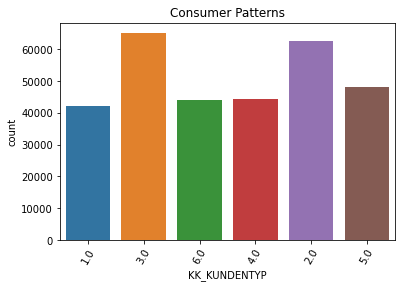

In [18]:
#plot categorical coutplot for features with high NaN percentage
sns.countplot(data=az, x='KK_KUNDENTYP')
plt.xticks(rotation = 60)
plt.title('Consumer Patterns')
plt.show()

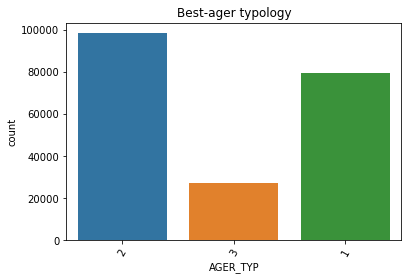

In [19]:
#plot categorical coutplot for features with high NaN percentage
sns.countplot(data=az, x='AGER_TYP')
plt.xticks(rotation = 60)
plt.title('Best-ager typology')
plt.show()

In [20]:
az[az.GEBURTSJAHR == '1902']

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
529966,NaN,4,1,NaN,3,1,5,1,1,4,...,2.0,3.0,2.0,1.0,1.0,4.0,3.0,2.0,4.0,3.0


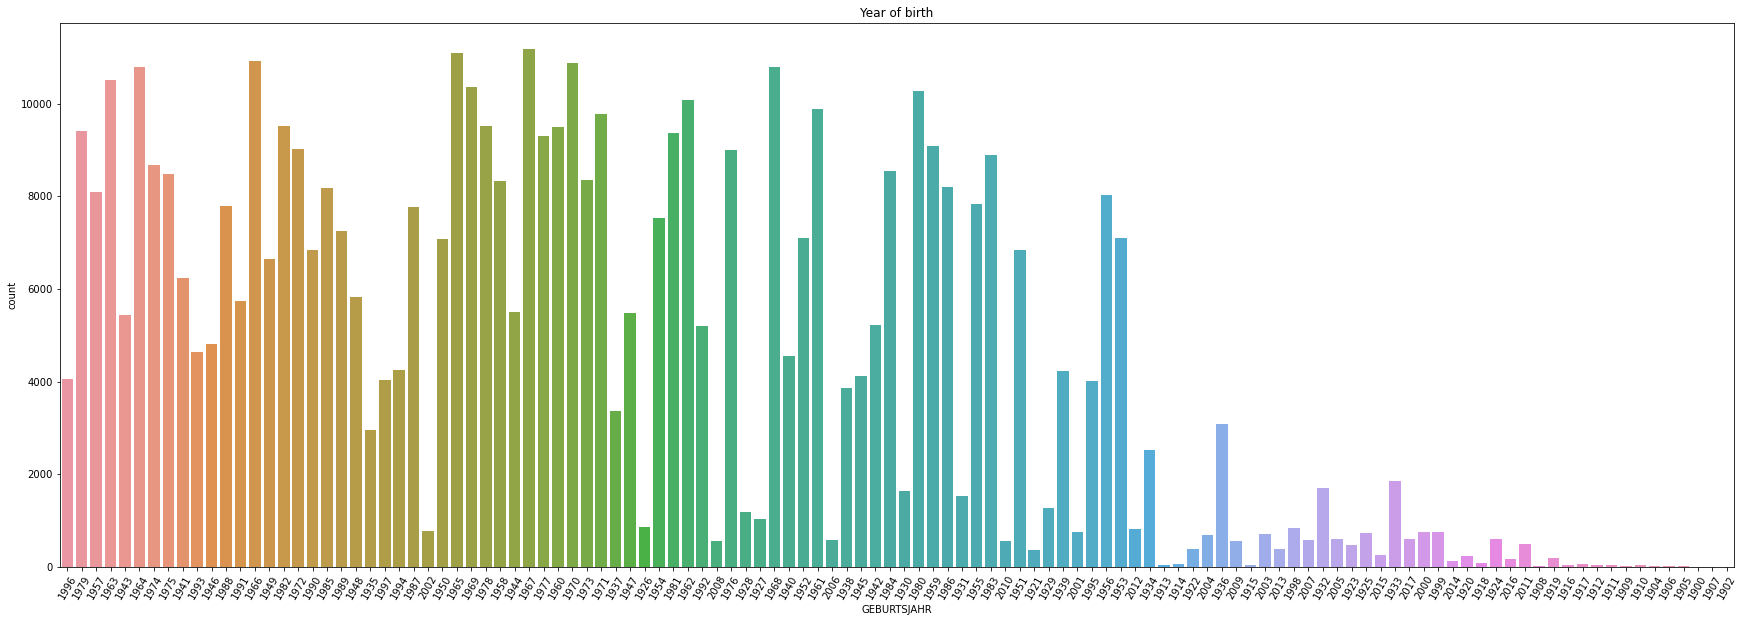

In [21]:
#plot categorical coutplot for features with high NaN percentage
plt.figure(figsize = [30, 10])
sns.countplot(data=az, x='GEBURTSJAHR')
plt.xticks(rotation = 60)
plt.title('Year of birth')
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column
We attach a dictionary holding the percentage of missing values in each column. Here we provide the most extreme data:

- 'GEBURTSJAHR': 44.02028228688507,
- 'KK_KUNDENTYP': 65.59674873011296,
- 'AGER_TYP': 76.95543529607134

The rest of features have less than 15% of missing data. 

'GEBURTSJAHR' is the year of birth, and as usually people do not feel like sharing their year of birth it is reasonable e do not explicitly have this data. 'AGER_TYP' is a category for elderly people so the fact that we are investigating all ages makes sense that information is limited because a lot of people do not fall in this category. 'KK_KUNDENTYP' is consumer patterns an elaborated classification we may be able to retrive from other sources.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [ ]:
# How much data is missing in each row of the dataset?
'''
row_missing_percentage = {}
def row_percentage_nulls(df):
    for row in df.index:
        #A function that creates a dictionary with percentage of nulls 
        #in each row and returns adictionary with sorted values 
        #print(df.index[row])
        try:
            #use numpy to save on time and energy
            row_percentage = (sum(np.isnan(azdias.loc[row, :].to_numpy().astype(float))))*100/df.shape[1]
            row_missing_percentage[row] = row_percentage
        except:
            #use pandas when we have string values in our rows
            row_percentage = df.loc[row, :].isnull().values.sum()*100/df.shape[1]
            row_missing_percentage[row] = row_percentage
            
    #return dictionarie's values sorted    
    return {k: v for k, v in sorted(row_missing_percentage.items(), key=lambda item: item[1])}
'''

In [ ]:
#save the percentage of nulls in a dictionary namely prc_idx_dict
'''
import time
s = time.time()
prc_idx_dict = row_percentage_nulls(az)
e = time.time()
print('Running time: {} minutes'.format(round((e-s)/60), 2) )
'''

In [ ]:
#It may take some time to create the dictinary so I saved it in a txt for future use!
'''
f = open("pct_dict.txt","w")
f.write( str(prc_idx_dict) )
f.close()
'''

In [22]:
#Load the percentaage dictionary we have previously saved
import ast
import time
from collections import OrderedDict

s = time.time()
file = open("pct_dict.txt", "r")

contents = file.read()
prc_idx_dict = ast.literal_eval(contents) #OrderedDict(ast.literal_eval(contents)) remembers the order entries were added

file.close()
e = time.time()
print('Running time: {} seconds'.format(e-s) )

Running time: 6.251359701156616 seconds


In [23]:
max_percentage = max(prc_idx_dict, key=prc_idx_dict.get) #this gives the key
min_percentage = min(prc_idx_dict, key=lambda key: prc_idx_dict[key]) #this gives the key

print('Max percentage of missing values in a row is {}'.format(prc_idx_dict.get(max_percentage))) ##this gives the value
print('Min percentage of missing values in a row is {}'.format(prc_idx_dict.get(min_percentage))) ##this gives the value

Max percentage of missing values in a row is 54.11764705882353
Min percentage of missing values in a row is 0.0


In [24]:
#Separate prc_idx_dict keys and values using numpy for quicker 
keys = np.fromiter(prc_idx_dict.keys(), dtype=float)
vals = np.fromiter(prc_idx_dict.values(), dtype=float)

In [25]:
# check the range of missing percentage
missing_range = np.unique(vals)
print(missing_range)
null_cats = [round(num, 1) for num in missing_range] # keep only two decimals 
nan_prc_cls = [10, 20, 30, 40, 50, 60] # create categories for percentage value categories
np.digitize(vals, nan_prc_cls) # categorize percentage values

[ 0.          1.17647059  2.35294118  3.52941176  4.70588235  5.88235294
  7.05882353  8.23529412  9.41176471 10.58823529 11.76470588 12.94117647
 14.11764706 15.29411765 16.47058824 17.64705882 18.82352941 20.
 21.17647059 22.35294118 23.52941176 24.70588235 25.88235294 27.05882353
 28.23529412 29.41176471 30.58823529 31.76470588 32.94117647 34.11764706
 35.29411765 36.47058824 37.64705882 38.82352941 40.         41.17647059
 42.35294118 43.52941176 49.41176471 51.76470588 52.94117647 54.11764706]


array([0, 0, 0, ..., 5, 5, 5], dtype=int64)

In [ ]:
plt.figure(figsize = [10, 10])
g = sns.violinplot(y = vals);

g.set_title('Count NaN Percentage values per row')
g.set_xlabel('Null Counts')
g.set_ylabel('Null percentage per row');

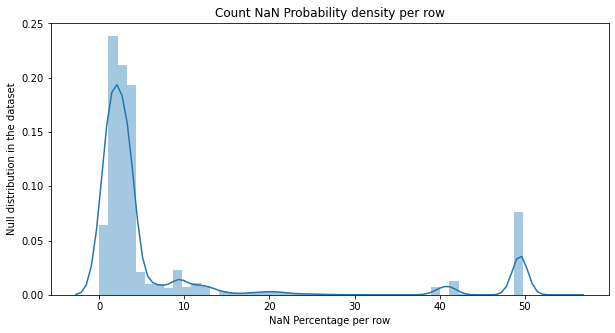

In [26]:
plt.figure(figsize = [10, 5])
g = sns.distplot(vals);

g.set_title('Count NaN Probability density per row')
g.set_xlabel('NaN Percentage per row')
g.set_ylabel('Null distribution in the dataset');

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
az_i =[idx for idx, value in prc_idx_dict.items() if value >30] #get index of more than 40% of missing values
az_ii =[idx for idx, value in prc_idx_dict.items() if value <= 30] #get index of less than 40% of missing values
azd_i = az.iloc[az_i] #az_i holds rows with more than 45% of nulls in rows
azd_ii = az.iloc[az_ii] #az_i holds rows with less than 45% of nulls in rows

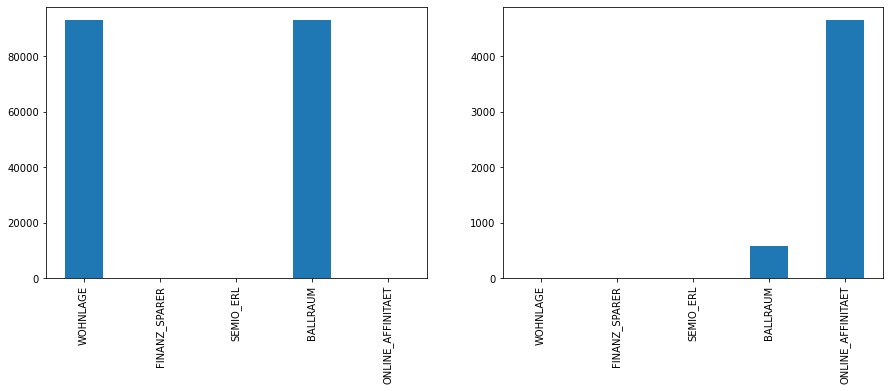

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
#choose randomly five columns
cols = az.sample(5, axis = 1).columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = [15, 5])

azd_i[cols].isnull().sum().plot(kind = 'bar', ax=axes[0])
azd_ii[cols].isnull().sum().plot(kind = 'bar', ax=axes[1]);

#### Discussion 1.1.3: Assess Missing Data in Each Row

In row level more than 50 % of rows have as much as 10% of missing values. 10 % of the reccord in the dataset have more than 50% of missing data. We need to take into cosideration the distribution of the percentage of missing values in rows. 


(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?
feat_info.columns

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')

In [30]:
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [31]:
#check column index to be treated differently with NaN's
for i in list(feat_info.type.unique()):
    print('{} features : {}'.format(i, tuple(feat_info[feat_info.type == i].index)))

categorical features : (0, 2, 3, 10, 12, 13, 17, 18, 19, 20, 21, 38, 39, 40, 41, 42, 47, 52, 55, 57, 58)
ordinal features : (1, 4, 5, 6, 7, 8, 9, 14, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 46, 48, 49, 53, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84)
numeric features : (11, 44, 45, 50, 51, 54, 74)
mixed features : (15, 16, 22, 56, 59, 64, 79)
interval features : (43,)


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [32]:
# Assess categorical variables
cat_az= az.iloc[:,[0, 2, 3, 10, 12, 13, 17, 18, 19, 20, 21, 38, 39, 40, 41, 42, 47, 52, 55, 57, 58]]

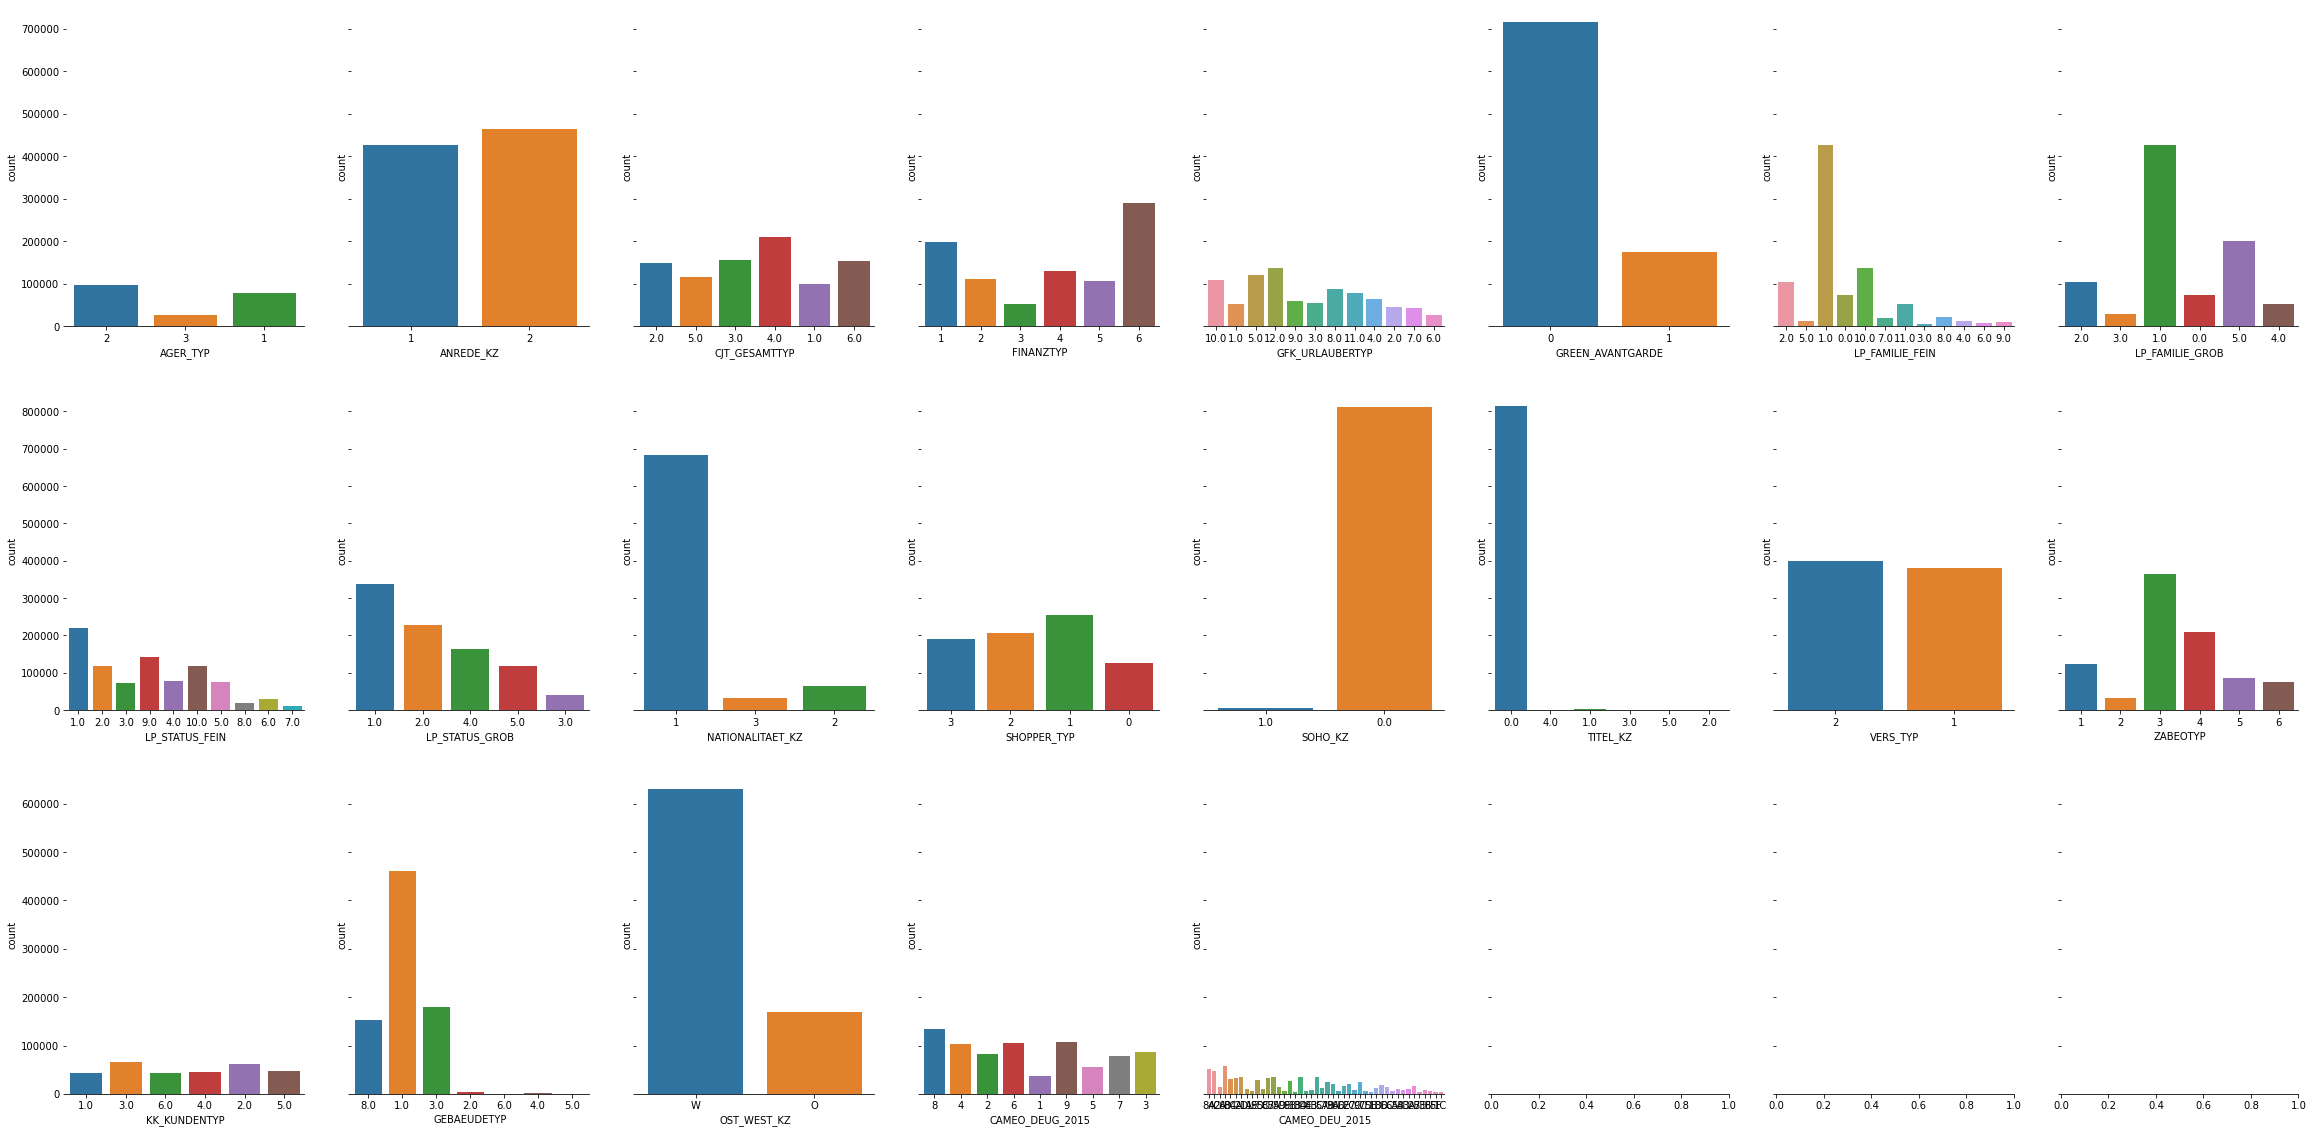

In [33]:
#Plot categorical features
# Set up the matplotlib figure
f, axes = plt.subplots(3, 8, figsize=(40, 20), sharey='row')
for ax, feature in zip(axes.flatten(), cat_az):  
    
    #sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(az[feature], ax=ax)

In [34]:
# Assess ordinal variables
ord_az= az.iloc[:,[1, 4, 5, 6, 7, 8, 9, 14, 23, 24, 25, 26, \
                    27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,\
                    46, 48, 49, 53, 60, 61, 62, 63, 65, 66, 67, \
                    68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80,\
                    81, 82, 83, 84]]



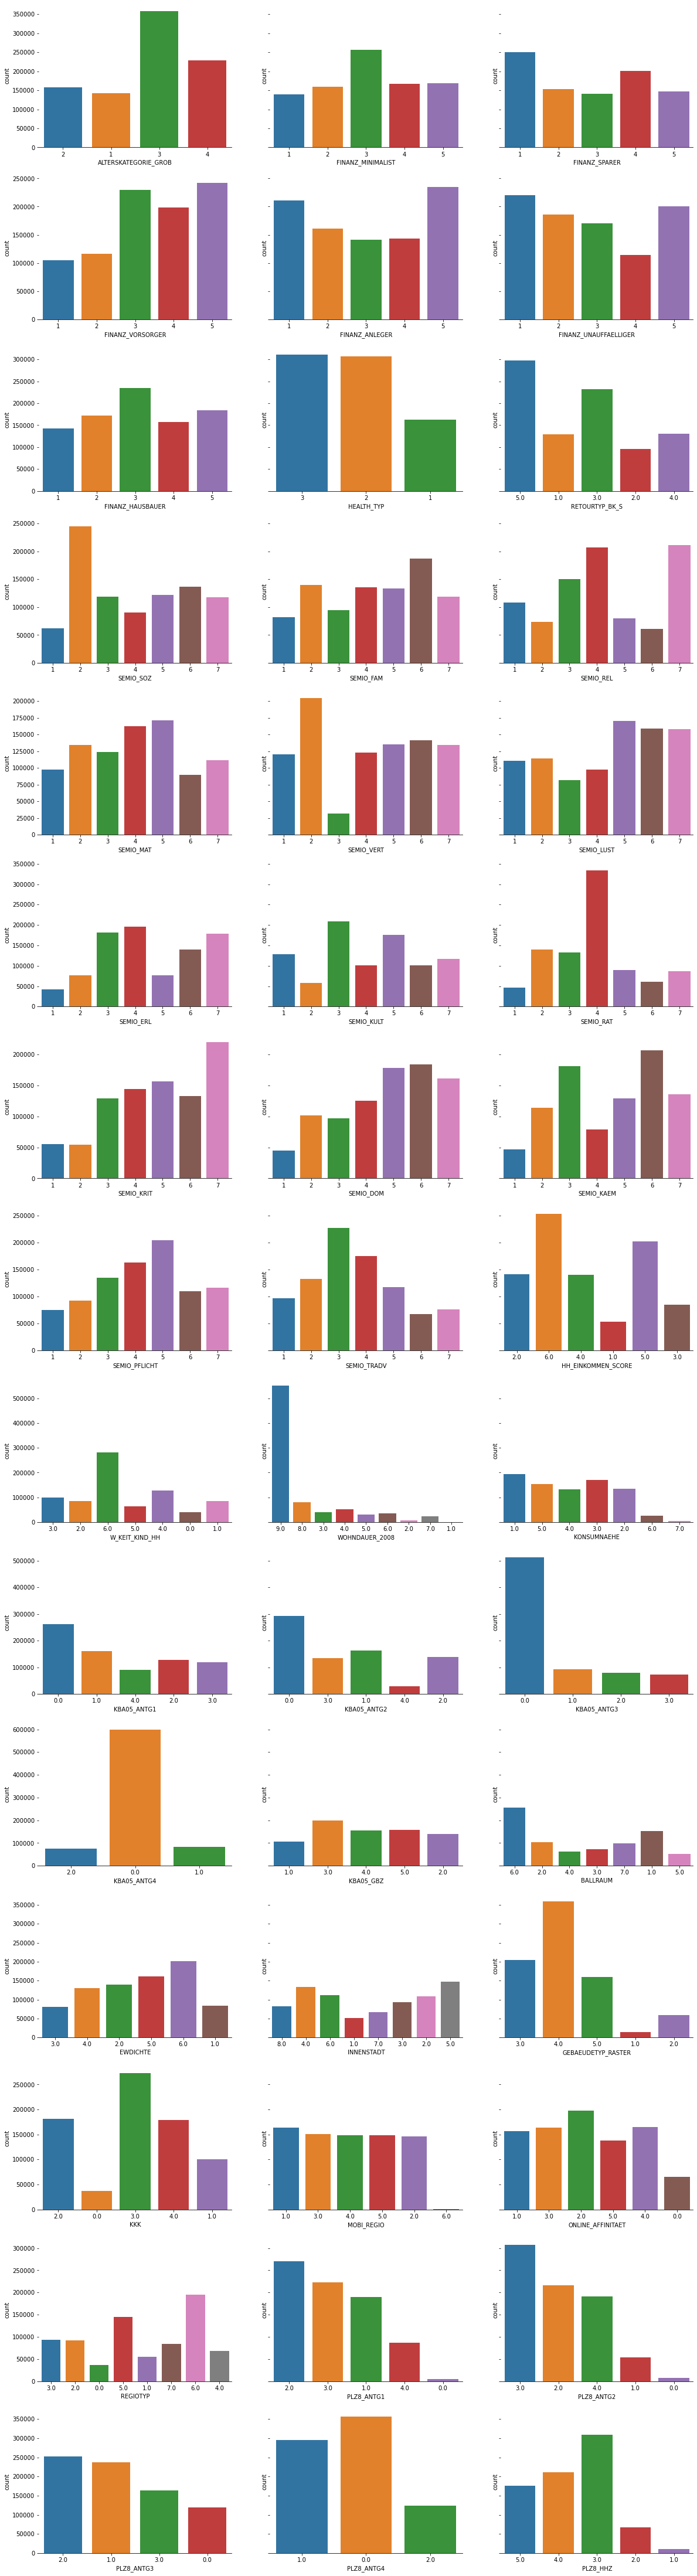

In [35]:
#Plot ordinal features
# Set up the matplotlib figure
f, axes = plt.subplots(15, 3, figsize=(20,80), sharey='row')
for ax, feature in zip(axes.flatten(), ord_az):  
    
    #sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(az[feature], ax=ax)

In [36]:
# Assess numeric variables
mix_az = az.iloc[:,[11, 44, 45, 50, 51, 54, 74]]

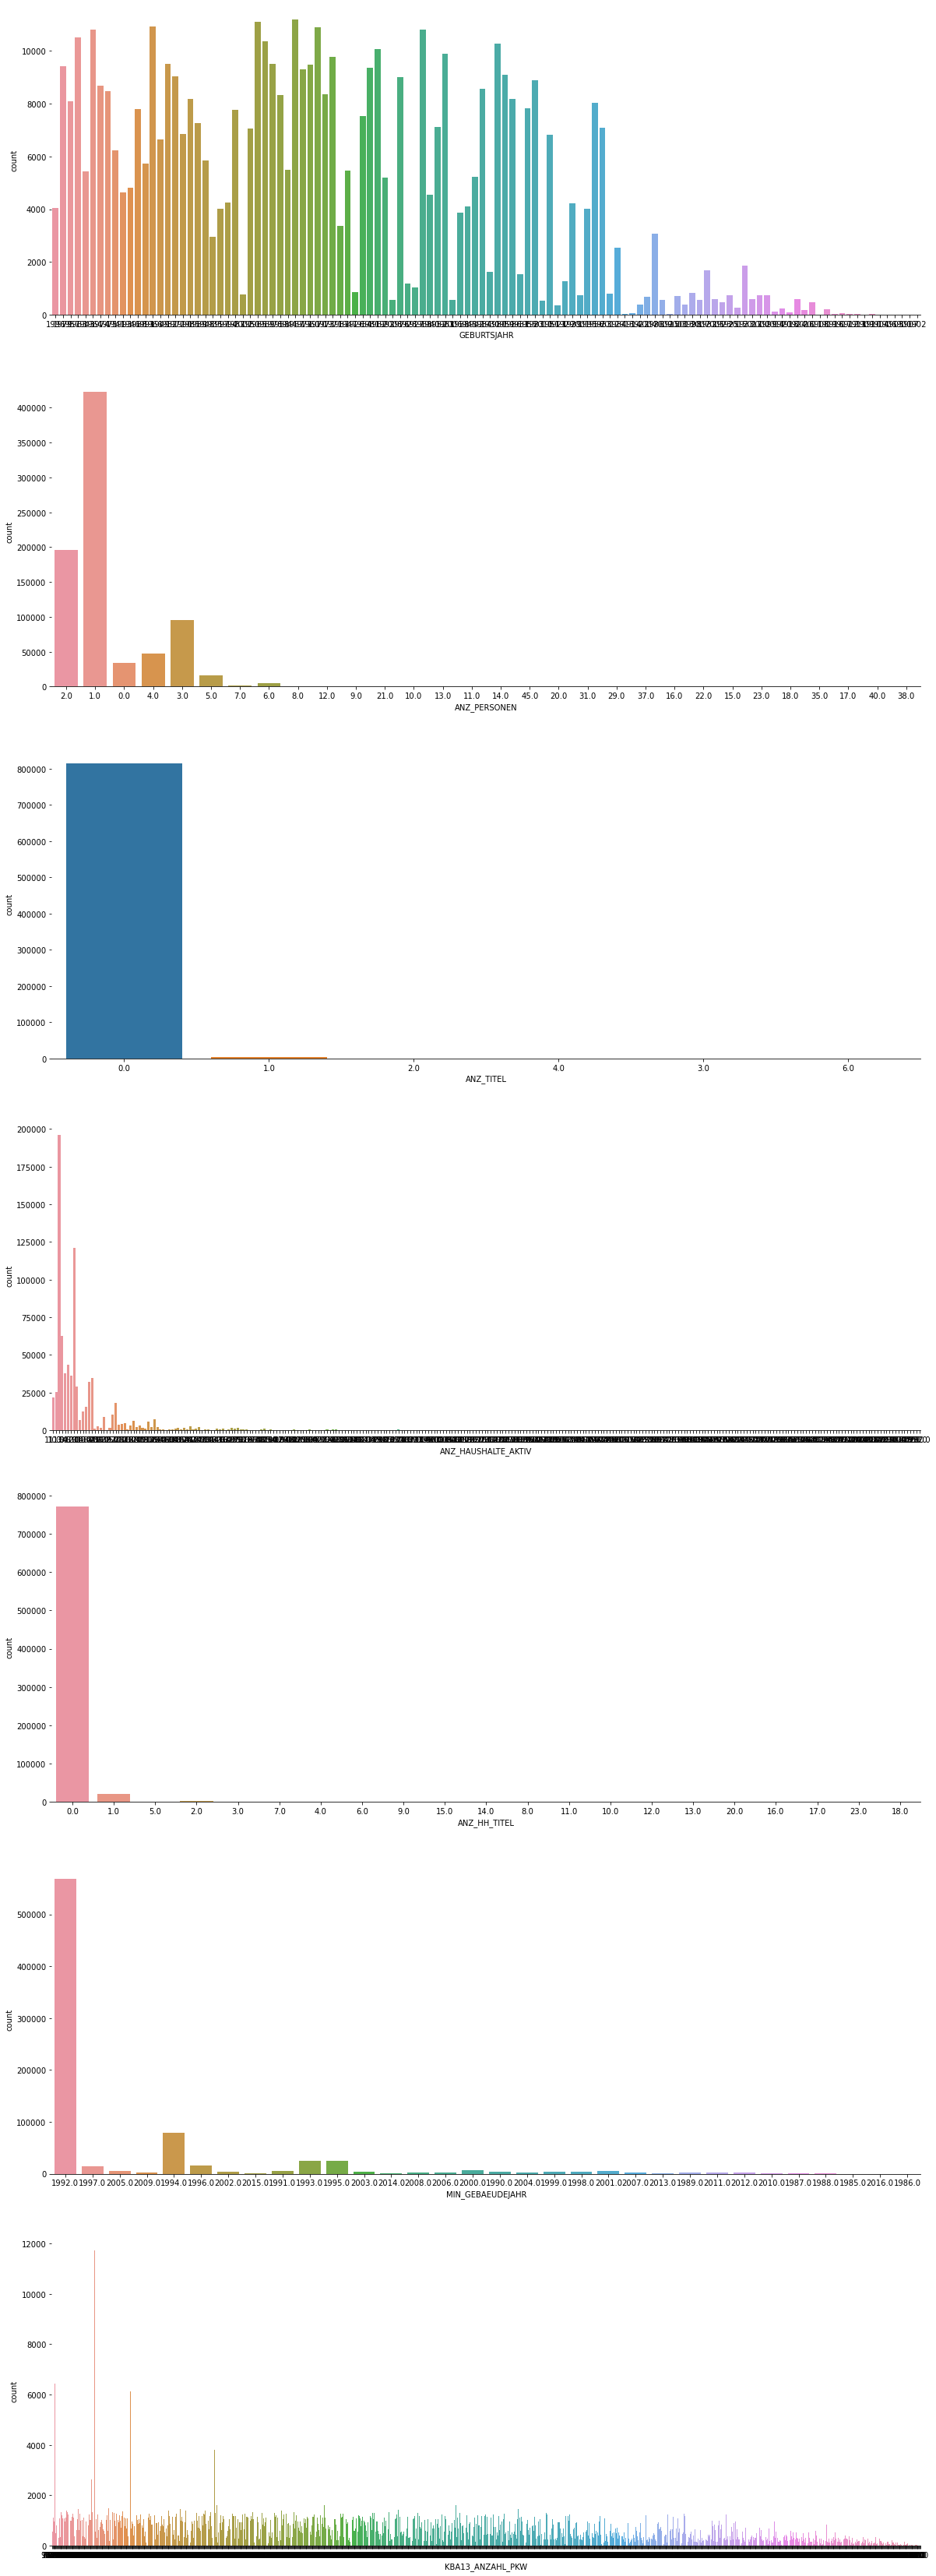

In [37]:
#Plot numeric features
# Set up the matplotlib figure
f, axes = plt.subplots(7, 1, figsize=(20,60), sharey='row')
for ax, feature in zip(axes.flatten(), mix_az):  
    
    #sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(az[feature], ax=ax)

In [38]:
# Assess mixed variables
num_az = az.iloc[:,[15, 16, 22, 56, 59, 64, 79]]

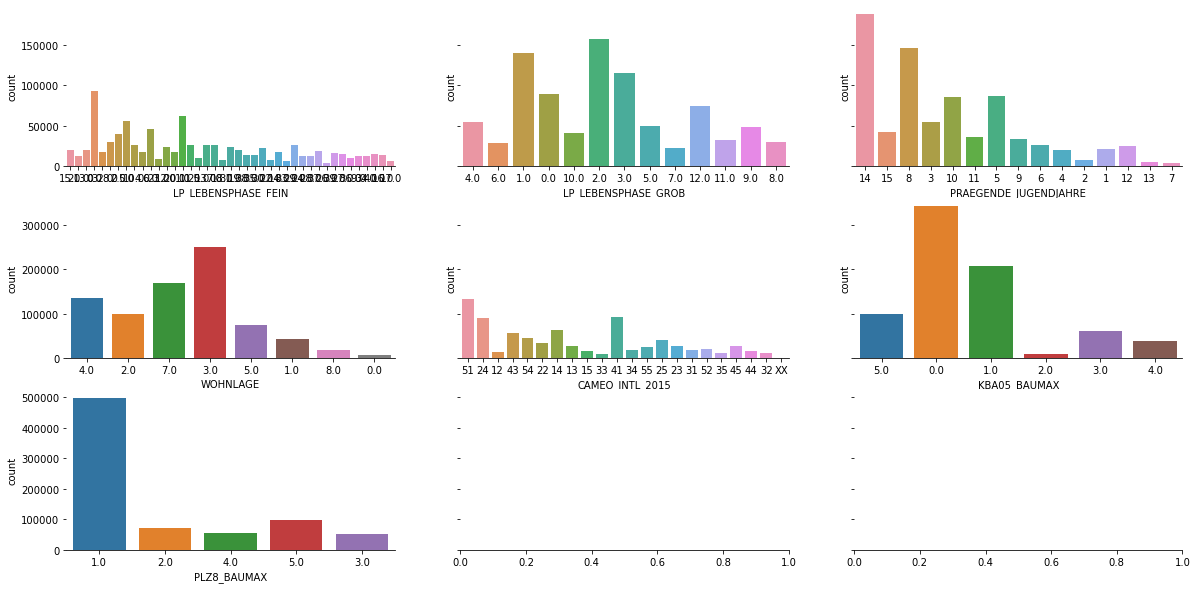

In [39]:
#Plot mixed features
# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(20,10), sharey='row')
for ax, feature in zip(axes.flatten(), num_az):  
    
    #sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(az[feature], ax=ax)

In [40]:
# Re-encode categorical variable(s) to be kept in the analysis.
#re-encode OST-WEST-KZ to keep
# Get one hot encoding of columns 'OST_WEST_KZ'
one_hot = pd.get_dummies(az['OST_WEST_KZ'])
# Drop column as it is now encoded
az = az.drop('OST_WEST_KZ',axis = 1)
# Join the encoded df
az = az.join(one_hot)
az 

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W
0,NaN,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,NaN,1,2,5.0,1,5,2,5,4,5,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1
2,NaN,3,2,3.0,1,4,1,2,3,5,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1
4,NaN,3,1,5.0,4,3,4,1,3,2,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,NaN,3,2,5.0,1,4,2,5,4,4,...,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN,0,1
891217,NaN,2,1,4.0,3,3,3,2,2,3,...,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0,0,1
891218,NaN,2,2,4.0,2,4,2,5,4,3,...,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0,0,1
891219,NaN,1,1,3.0,1,5,3,5,5,5,...,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features

I want to keep things super simpe in order to complete the analysis and do some practice on PCA so:
- I re-encode `OST-WEST-KZ` as a binary variable that takes on non-numeric value
- I keep categoricals that take numeric values as is
- I choose to drop multi-level categoricals (three or more values), from this analysis for practical reasons as I have limited capacity in my machine to elaborate a big dataset.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### Work on `"PRAEGENDE_JUGENDJAHRE"`

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [41]:
az['PRAEGENDE_JUGENDJAHRE'].value_counts()

14    188697
8     145988
5      86416
10     85808
3      55195
15     42547
11     35752
9      33570
6      25652
12     24446
1      21282
4      20451
2       7479
13      5764
7       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [42]:
jug_dict = {0: 'Uknown',
1: '40s - war years (Mainstream, E+W)',
2: '40s - reconstruction years (Avantgarde, E+W)',
3: '50s - economic miracle (Mainstream, E+W)',
4: '50s - milk bar / Individualisation (Avantgarde, E+W)',
5: '60s - economic miracle (Mainstream, E+W)',
6: '60s - generation 68 / student protestors (Avantgarde, W)',
7: '60s - opponents to the building of the Wall (Avantgarde, E)',
8: '70s - family orientation (Mainstream, E+W)',
9: '70s - peace movement (Avantgarde, E+W)',
10: '80s - Generation Golf (Mainstream, W)',
11: '80s - ecological awareness (Avantgarde, W)',
12: '80s - FDJ / communist party youth organisation (Mainstream, E)',
13: '80s - Swords into ploughshares (Avantgarde, E)',
14: '90s - digital media kids (Mainstream, E+W)',
15: '90s - ecological awareness (Avantgarde, E+W)'}


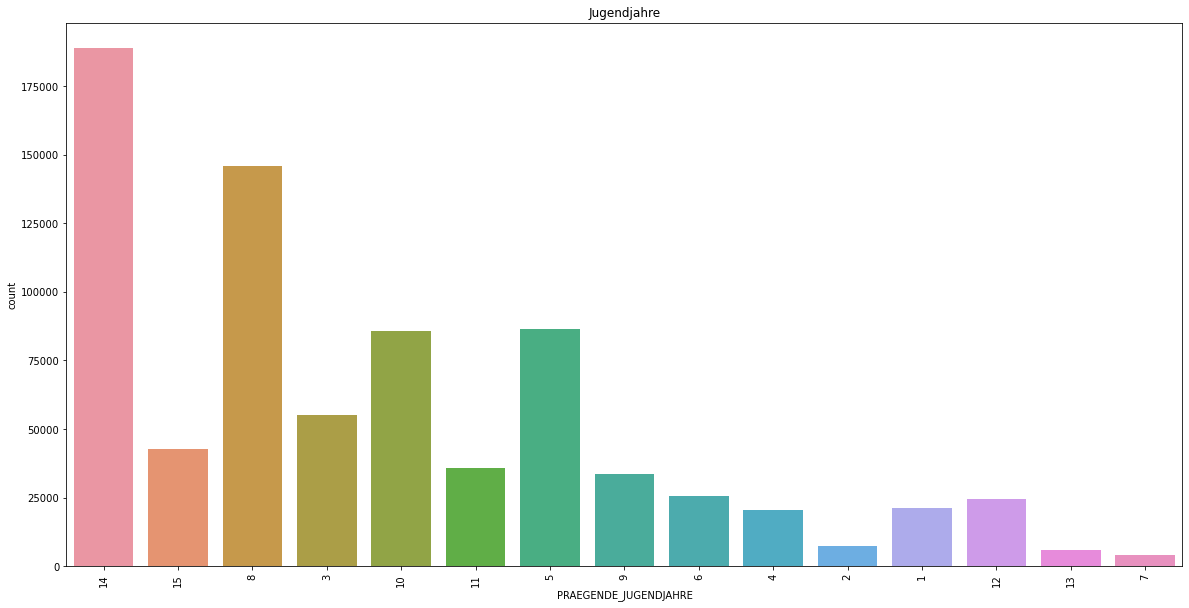

In [43]:
#az["PRAEGENDE_JUGENDJAHRE"] = az["PRAEGENDE_JUGENDJAHRE"].fillna('nan')
plt.figure(figsize = [20, 10])
sns.countplot(data=az, x='PRAEGENDE_JUGENDJAHRE')
plt.xticks(rotation = 90,)
plt.title('Jugendjahre')
plt.show()

**Create Decades feature**

In [44]:
#select indexes for new feature
decade_40 = az.query("PRAEGENDE_JUGENDJAHRE == '1' or PRAEGENDE_JUGENDJAHRE == '2'").index 
decade_50 = az.query("PRAEGENDE_JUGENDJAHRE == '3' or PRAEGENDE_JUGENDJAHRE == '4'").index 
decade_60 = az.query("PRAEGENDE_JUGENDJAHRE == '5' or PRAEGENDE_JUGENDJAHRE == '6' \
                   or PRAEGENDE_JUGENDJAHRE == '7'").index
decade_70 = az.query("PRAEGENDE_JUGENDJAHRE == '8' or PRAEGENDE_JUGENDJAHRE == '9'").index 
decade_80 = az.query("PRAEGENDE_JUGENDJAHRE == '10' or PRAEGENDE_JUGENDJAHRE == '11' or PRAEGENDE_JUGENDJAHRE == '12' \
                        or PRAEGENDE_JUGENDJAHRE == '13'").index 
decade_90 = az.query("PRAEGENDE_JUGENDJAHRE == '14' or PRAEGENDE_JUGENDJAHRE == '15'").index 

In [45]:
#apply indexes in the dataframe
az['decades'] = 0
az.loc[decade_40, 'decades'] = 1
az.loc[decade_50, 'decades'] = 2
az.loc[decade_60, 'decades'] = 3
az.loc[decade_70, 'decades'] = 4
az.loc[decade_80, 'decades'] = 5
az.loc[decade_90, 'decades'] = 6

In [46]:
az['decades'].value_counts()

6    231244
4    179558
5    151770
3    116078
0    108164
2     75646
1     28761
Name: decades, dtype: int64

In [47]:
#Convert decades to categorical type
az.decades.astype('category');

In [48]:
#Convert to ordered categorical type with custom ordering:
cat_decades = pd.api.types.CategoricalDtype (categories=[0, 1, 2, 3, 4, 5, 6], ordered=True)
az.decades.astype(cat_decades);

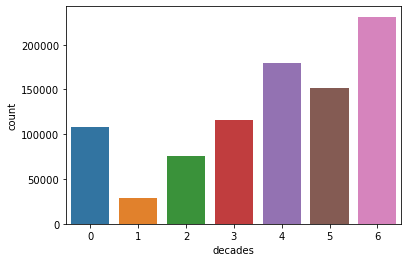

In [49]:
sns.countplot(az.decades);

We remember category 0 is Unknown values, they sould be treated as Nan

**Create Movement Variable** 

In [50]:
#Select Avantage values in PRAEGENDE_JUGENDJAHRE feature
Avantage = [k for k, v in jug_dict.items() if 'Avantgarde' in v]
Avantage

[2, 4, 6, 7, 9, 11, 13, 15]

In [51]:
#Select Mainstream values in PRAEGENDE_JUGENDJAHRE feature
Mainstream = [k for k, v in jug_dict.items() if 'Mainstream' in v]
Mainstream

[1, 3, 5, 8, 10, 12, 14]

In [52]:
avtg_index = az.query("PRAEGENDE_JUGENDJAHRE == ['2', '4', '6', '7', '9', '11', '13', '15']").index
mns_index = az.query("PRAEGENDE_JUGENDJAHRE == ['1', '3', '5', '8', '10', '12', '14']").index

In [53]:
#apply indexes in the dataframe
az['movement'] = 0
az.loc[avtg_index, 'movement'] = 1
az.loc[mns_index, 'movement'] = 2

In [54]:
#Convert movement to categorical type
az.movement.astype('category');

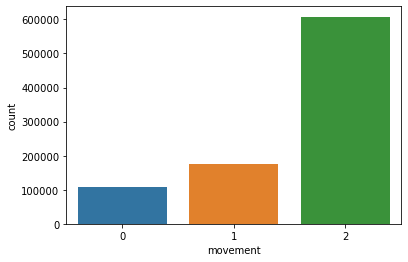

In [55]:
sns.countplot(az.movement);

Fix all Uknown values now

In [56]:
az.PRAEGENDE_JUGENDJAHRE.value_counts()

14    188697
8     145988
5      86416
10     85808
3      55195
15     42547
11     35752
9      33570
6      25652
12     24446
1      21282
4      20451
2       7479
13      5764
7       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

### Work on `CAMEO_INTL_2015`

Create **household variable**

In [57]:
#Remove NaN and 'nan' replaced from NaN as strings to perform filtering
az['CAMEO_INTL_2015'] = az.CAMEO_INTL_2015.astype('str').replace(np.nan, '0').replace('nan', '0').replace('NaN', '0')

In [58]:
#check null values
az.CAMEO_INTL_2015.isnull().sum()

0

Ok with no null values we can proceed

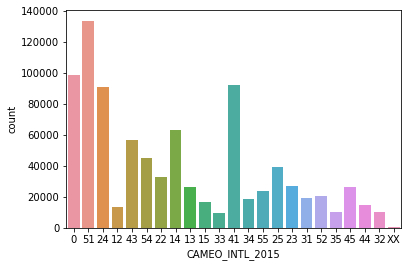

In [59]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
sns.countplot(az.CAMEO_INTL_2015);

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [60]:
cameo_dict = {'-1': 'unknown',
11: 'Wealthy Households - Pre-Family Couples & Singles',
12: 'Wealthy Households - Young Couples With Children',
13: 'Wealthy Households - Families With School Age Children',
14: 'Wealthy Households - Older Families & Mature Couples',
15: 'Wealthy Households - Elders In Retirement',
21: 'Prosperous Households - Pre-Family Couples & Singles',
22: 'Prosperous Households - Young Couples With Children',
23: 'Prosperous Households - Families With School Age Children',
24: 'Prosperous Households - Older Families & Mature Couples',
25: 'Prosperous Households - Elders In Retirement',
31: 'Comfortable Households - Pre-Family Couples & Singles',
32: 'Comfortable Households - Young Couples With Children',
33: 'Comfortable Households - Families With School Age Children',
34: 'Comfortable Households - Older Families & Mature Couples',
35: 'Comfortable Households - Elders In Retirement',
41: 'Less Affluent Households - Pre-Family Couples & Singles',
42: 'Less Affluent Households - Young Couples With Children',
43: 'Less Affluent Households - Families With School Age Children',
44: 'Less Affluent Households - Older Families & Mature Couples',
45: 'Less Affluent Households - Elders In Retirement',
51: 'Poorer Households - Pre-Family Couples & Singles',
52: 'Poorer Households - Young Couples With Children',
53: 'Poorer Households - Families With School Age Children',
54: 'Poorer Households - Older Families & Mature Couples',
55: 'Poorer Households - Elders In Retirement',
'XX': 'unknown'}

In [61]:
#Select Wealthy houses in CAMEO_INTL_2015 feature
Wealthy = [k for k, v in cameo_dict.items() if 'Wealthy' in v]
print('Wealthy: {}'.format(Wealthy))
#Select Wealthy houses in CAMEO_INTL_2015 feature
Prosperous = [k for k, v in cameo_dict.items() if 'Prosperous' in v]
print('Prosperous: {}'.format(Prosperous))
Comfortable = [k for k, v in cameo_dict.items() if 'Comfortable' in v]
print('Comfortable: {}'.format(Comfortable))
Less_Affluent = [k for k, v in cameo_dict.items() if 'Less Affluent' in v]
print('Less Affluent: {}'.format(Less_Affluent))
Poorer = [k for k, v in cameo_dict.items() if 'Poorer' in v]
print('Poorer: {}'.format(Poorer))

Wealthy: [11, 12, 13, 14, 15]
Prosperous: [21, 22, 23, 24, 25]
Comfortable: [31, 32, 33, 34, 35]
Less Affluent: [41, 42, 43, 44, 45]
Poorer: [51, 52, 53, 54, 55]


In [62]:
wealthy_index = az.query("CAMEO_INTL_2015 == ['11', '12', '13', '14', '15']").index
prosperous_index = az.query("CAMEO_INTL_2015 == ['21', '22', '23', '24', '25']").index
comfortable_index = az.query("CAMEO_INTL_2015 == ['31', '32', '33', '34', '35']").index
less_Affluent_index = az.query("CAMEO_INTL_2015 == ['41', '42', '43', '44', '45']").index
poorer_index = az.query("CAMEO_INTL_2015 == ['51', '52', '53', '54', '55']").index

In [63]:
#apply indexes in the dataframe
az['household'] = 0
az.loc[wealthy_index, 'household'] = 5
az.loc[prosperous_index, 'household'] = 4
az.loc[comfortable_index, 'household'] = 3
az.loc[less_Affluent_index, 'household'] = 2
az.loc[poorer_index, 'household'] = 1

In [64]:
#Convert hosehold to categorical type
az.household.astype('category');

In [65]:
#Convert to ordered categorical type with custom ordering:
cat_household = pd.api.types.CategoricalDtype (categories=[0, 1, 2, 3, 4, 5], ordered=True)
az.household.astype(cat_household);

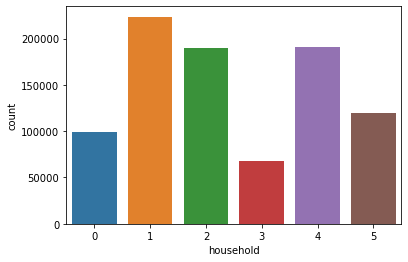

In [66]:
sns.countplot(az.household);

**Create nucleo feature**

In [67]:
#Select single family values in CAMEO_INTL_2015 feature
singles = [str(k) for k, v in cameo_dict.items() if 'Singles' in v]
#Select young family values in CAMEO_INTL_2015 feature
young = [str(k) for k, v in cameo_dict.items() if 'Young' in v]
#Select School family values in CAMEO_INTL_2015 feature
school = [str(k) for k, v in cameo_dict.items() if 'School' in v]
#Select Mature family values in CAMEO_INTL_2015 feature
mature = [str(k) for k, v in cameo_dict.items() if 'Mature' in v]
#Select Elders family values in CAMEO_INTL_2015 feature
elders = [str(k) for k, v in cameo_dict.items() if 'Elders' in v]
print(singles, young, school, mature, elders)

['11', '21', '31', '41', '51'] ['12', '22', '32', '42', '52'] ['13', '23', '33', '43', '53'] ['14', '24', '34', '44', '54'] ['15', '25', '35', '45', '55']


In [68]:
singles_index = az.query("CAMEO_INTL_2015 == ['11', '21', '31', '41', '51']").index
young_index = az.query("CAMEO_INTL_2015 == ['12', '22', '32', '42', '52']").index
school_index = az.query("CAMEO_INTL_2015 == ['13', '23', '33', '43', '53']").index
mature_index = az.query("CAMEO_INTL_2015 == ['14', '24', '34', '44', '54']").index
elders_index = az.query("CAMEO_INTL_2015 == ['15', '25', '35', '45', '55']").index

In [69]:
#apply indexes in the dataframe
az['nucleo'] = 0
az.loc[elders_index, 'nucleo'] = 5
az.loc[mature_index, 'nucleo'] = 4
az.loc[school_index, 'nucleo'] = 3
az.loc[young_index, 'nucleo'] = 2
az.loc[singles_index, 'nucleo'] = 1

In [70]:
#Convert nucleo to categorical type
az.nucleo.astype('category');

In [71]:
#Convert to ordered categorical type with custom ordering:
cat_nucleo = pd.api.types.CategoricalDtype (categories=[0, 1, 2, 3, 4, 5], ordered=True)
az.nucleo.astype(cat_nucleo);

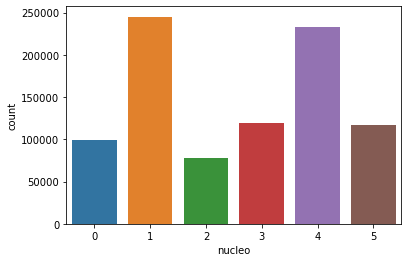

In [72]:
sns.countplot(az.nucleo);

#### Discussion 1.2.2: Engineer Mixed-Type Features

We have created two ordinal features: `nucleo`, `household`, `decades`
And one binary variable: `movement`

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [73]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
for column in az.iloc[:,[0, 2, 3, 10, 12, 13, 17, 18, 19, 20, 21, 38, 39, 40, 41, 42, 47, 52, 55, 57, 58]].columns:
    if len(az[column].unique()) >= 3:
        az.drop(column, axis =1, inplace = True)
        print(f'Deleted {column}')

Deleted AGER_TYP
Deleted CJT_GESAMTTYP
Deleted FINANZTYP
Deleted GFK_URLAUBERTYP
Deleted LP_FAMILIE_FEIN
Deleted LP_FAMILIE_GROB
Deleted LP_STATUS_FEIN
Deleted LP_STATUS_GROB
Deleted NATIONALITAET_KZ
Deleted SHOPPER_TYP
Deleted SOHO_KZ
Deleted TITEL_KZ
Deleted VERS_TYP
Deleted ZABEOTYP
Deleted KK_KUNDENTYP
Deleted GEBAEUDETYP
Deleted WOHNLAGE
Deleted CAMEO_DEU_2015
Deleted CAMEO_INTL_2015


In [74]:
#Delete columns with nulls more than 35%
drop_threashold_nulls(az)

Droped GEBURTSJAHR column.


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W,decades,movement,household,nucleo
0,2,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,1,2,1,5,2,5,4,5,0,3,...,4.0,3.0,5.0,4.0,0,1,6,2,1,1
2,3,2,1,4,1,2,3,5,1,3,...,4.0,3.0,5.0,2.0,0,1,6,1,4,4
3,4,2,4,2,5,2,1,2,0,2,...,4.0,2.0,3.0,3.0,0,1,4,2,5,2
4,3,1,4,3,4,1,3,2,0,3,...,3.0,4.0,6.0,5.0,0,1,4,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3,2,1,4,2,5,4,4,0,3,...,3.0,NaN,NaN,NaN,0,1,6,2,2,1
891217,2,1,3,3,3,2,2,3,0,NaN,...,3.0,4.0,6.0,5.0,0,1,5,2,1,1
891218,2,2,2,4,2,5,4,3,0,1,...,4.0,2.0,2.0,3.0,0,1,6,2,4,4
891219,1,1,1,5,3,5,5,5,0,1,...,1.0,4.0,7.0,5.0,0,1,6,2,1,1


In [75]:
#drop Nan Values here
az.dropna(inplace = True)

In [76]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
#create final Dataframe
#reset index
az.reset_index(drop=True)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W,decades,movement,household,nucleo
0,1,2,1,5,2,5,4,5,0,3,...,4.0,3.0,5.0,4.0,0,1,6,2,1,1
1,3,2,1,4,1,2,3,5,1,3,...,4.0,3.0,5.0,2.0,0,1,6,1,4,4
2,3,1,4,3,4,1,3,2,0,3,...,3.0,4.0,6.0,5.0,0,1,4,2,2,3
3,1,2,3,1,5,2,2,5,0,3,...,5.0,2.0,3.0,3.0,0,1,2,2,1,4
4,2,2,1,5,1,5,4,3,0,2,...,5.0,4.0,6.0,3.0,0,1,5,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658469,4,2,3,3,3,5,3,2,1,1,...,5.0,3.0,4.0,4.0,0,1,5,1,3,4
658470,1,2,1,5,2,3,3,4,0,3,...,2.0,3.0,7.0,3.0,0,1,6,2,4,3
658471,2,2,1,5,2,4,5,4,0,2,...,4.0,2.0,5.0,2.0,0,1,5,2,3,1
658472,1,1,1,5,3,5,5,5,0,1,...,1.0,4.0,7.0,5.0,0,1,6,2,1,1


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [77]:
jug_dict = {0: 'Uknown',
1: '40s - war years (Mainstream, E+W)',
2: '40s - reconstruction years (Avantgarde, E+W)',
3: '50s - economic miracle (Mainstream, E+W)',
4: '50s - milk bar / Individualisation (Avantgarde, E+W)',
5: '60s - economic miracle (Mainstream, E+W)',
6: '60s - generation 68 / student protestors (Avantgarde, W)',
7: '60s - opponents to the building of the Wall (Avantgarde, E)',
8: '70s - family orientation (Mainstream, E+W)',
9: '70s - peace movement (Avantgarde, E+W)',
10: '80s - Generation Golf (Mainstream, W)',
11: '80s - ecological awareness (Avantgarde, W)',
12: '80s - FDJ / communist party youth organisation (Mainstream, E)',
13: '80s - Swords into ploughshares (Avantgarde, E)',
14: '90s - digital media kids (Mainstream, E+W)',
15: '90s - ecological awareness (Avantgarde, E+W)'}

In [78]:
cameo_dict = {'-1': 'unknown',
11: 'Wealthy Households - Pre-Family Couples & Singles',
12: 'Wealthy Households - Young Couples With Children',
13: 'Wealthy Households - Families With School Age Children',
14: 'Wealthy Households - Older Families & Mature Couples',
15: 'Wealthy Households - Elders In Retirement',
21: 'Prosperous Households - Pre-Family Couples & Singles',
22: 'Prosperous Households - Young Couples With Children',
23: 'Prosperous Households - Families With School Age Children',
24: 'Prosperous Households - Older Families & Mature Couples',
25: 'Prosperous Households - Elders In Retirement',
31: 'Comfortable Households - Pre-Family Couples & Singles',
32: 'Comfortable Households - Young Couples With Children',
33: 'Comfortable Households - Families With School Age Children',
34: 'Comfortable Households - Older Families & Mature Couples',
35: 'Comfortable Households - Elders In Retirement',
41: 'Less Affluent Households - Pre-Family Couples & Singles',
42: 'Less Affluent Households - Young Couples With Children',
43: 'Less Affluent Households - Families With School Age Children',
44: 'Less Affluent Households - Older Families & Mature Couples',
45: 'Less Affluent Households - Elders In Retirement',
51: 'Poorer Households - Pre-Family Couples & Singles',
52: 'Poorer Households - Young Couples With Children',
53: 'Poorer Households - Families With School Age Children',
54: 'Poorer Households - Older Families & Mature Couples',
55: 'Poorer Households - Elders In Retirement',
'XX': 'unknown'}

In [79]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    #######################################################
    # Put in code here to execute all main cleaning steps:#
    # convert missing value codes into NaNs, ...          #
    #######################################################
    
    for col in feat_info[feat_info.missing_or_unknown == '[-1,0]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan).replace('0', np.nan)
        print('Replaced [-1,0] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1,0,9]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan).replace('0', np.nan).replace('9', np.nan)
        print('Replaced [-1,0,9] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[0]'].attribute:
        df[col] = df[col].astype('str').replace('0', np.nan)
        print('Replaced [0] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan)
        print('Replaced [-1] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[]'].attribute:
        df[col] = df[col].astype('str').replace(r'^\s*$', np.nan, regex=True)
        print('Replaced [] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1,9]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan).replace('9', np.nan)
        print('Replaced [-1,9] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1,X]'].attribute:
        df[col] = df[col].astype('str').replace('-1', np.nan).replace('X', np.nan)
        print('Replaced [-1,X] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[XX]'].attribute:
        df[col] = df[col].astype('str').replace('XX', np.nan)
        print('Replaced [XX] values in {} column'.format(col))
    for col in feat_info[feat_info.missing_or_unknown == '[-1,XX]'].attribute:
        df[col] = df[col].astype('str').replace('-1,XX', np.nan)
        print('Replaced [-1,XX] values in {} column'.format(col))
        
    print('Replacing {}, {} or {} strings'.format('nan', 'NaN', 'empty spaces'))
        
    for df_col in df.columns:
        df[df_col] = df[df_col].astype('str').replace('nan',\
                                                      np.nan).replace('NaN', np.nan).replace(r'^\s*$', np.nan, regex=True)
    
    
    
    #########################################
    # remove selected columns and rows, ...##
    #########################################
    
    #remove non binary categorical values to optimize limited calculation performance
    for column in df.iloc[:,[0, 2, 3, 10, 12, 13, 17, 18, 19, 20, 21, 38, 39, 40, 41, 42, 47, 52, 55, 57, 58]].columns:
        if len(df[column].unique()) > 3:
            df.drop(column, axis =1, inplace = True)
            print(f'Deleted {column}')
    
    #remove columns with more than 35% NaNs
    for col in df.columns:
        '''A loop that drops columns for missing information higher than 35% of entire column'''
        if df[col].isnull().values.sum()*100/df.shape[0] > 35:
            try:
                df.drop(col, axis =1, inplace = True)
                print('Droping {} column'.format(col))
            except TypeError:
                print(col, df[col])
    
    #drop the rest of NaN values here           
    df.dropna(inplace = True)
        
        
    
    #################################################
    # select, re-encode, and engineer column values.#
    #################################################
    
    #select only catecory columns and drop non binary values for simplicity
    
    #fix east west variable with one hot encoding
    # Get one hot encoding of columns 'OST_WEST_KZ'
    one_hot = pd.get_dummies(df['OST_WEST_KZ'])
    # Drop column as it is now encoded
    df = df.drop('OST_WEST_KZ',axis = 1)
    print('Drop OST_WEST_KZ column as it is now encoded')
    # Join the encoded df
    df = df.join(one_hot)
    print('Join O, W hot encoded variables')
    
    print(df['O'])
    print(df['W'])
    #select string indexes for new decades feature
    print('Selecting Decade Indexes')
    decade_40 = df.query("PRAEGENDE_JUGENDJAHRE == ['1', '2']").index 
    decade_50 = df.query("PRAEGENDE_JUGENDJAHRE == ['3', '4']").index 
    decade_60 = df.query("PRAEGENDE_JUGENDJAHRE == ['5', '6', '7']").index
    decade_70 = df.query("PRAEGENDE_JUGENDJAHRE == ['8', '9']").index 
    decade_80 = df.query("PRAEGENDE_JUGENDJAHRE == ['10', '11', '12', '13']").index 
    decade_90 = df.query("PRAEGENDE_JUGENDJAHRE == ['14', '15']").index 
    
    #apply decades indexes to the dataframe
    print('Applying Decade Indexes')
    df['decades'] = 0
    df.loc[decade_40, 'decades'] = 1
    df.loc[decade_50, 'decades'] = 2
    df.loc[decade_60, 'decades'] = 3
    df.loc[decade_70, 'decades'] = 4
    df.loc[decade_80, 'decades'] = 5
    df.loc[decade_90, 'decades'] = 6
    
    # select string indexes for new movement feature
    print('Selecting Movement Indexes')
    avtg_index = df.query("PRAEGENDE_JUGENDJAHRE == ['2','4','6', '7', '9', '11', '13', '15']").index
    mns_index = df.query("PRAEGENDE_JUGENDJAHRE == ['1', '3', '5', '8', '10', '12', '14']").index
    
    #apply movement indexes to the dataframe
    print('Applying Movemet Indexes')
    df['movement'] = 0
    df.loc[avtg_index, 'movement'] = 1
    df.loc[mns_index, 'movement'] = 2
    
    #select indexes for new household feature
    print('Selecting Household Indexes')
    wealthy_index = df.query("CAMEO_INTL_2015 == ['11', '12', '13', '14', '15']").index
    prosperous_index = df.query("CAMEO_INTL_2015 == ['21', '22', '23', '24', '25']").index
    comfortable_index = df.query("CAMEO_INTL_2015 == ['31', '32', '33', '34', '35']").index
    less_Affluent_index = df.query("CAMEO_INTL_2015 == ['41', '42', '43', '44', '45']").index
    poorer_index = df.query("CAMEO_INTL_2015 == ['51', '52', '53', '54', '55']").index
    
    #apply household indexes in the dataframe
    print('Applying Household Indexes')
    df['household'] = 0
    df.loc[wealthy_index, 'household'] = 5
    df.loc[prosperous_index, 'household'] = 4
    df.loc[comfortable_index, 'household'] = 3
    df.loc[less_Affluent_index, 'household'] = 2
    df.loc[poorer_index, 'household'] = 1
    
    #select indexes for new nucleo feature
    print('Selecting Nucleo Indexes')
    singles_index = df.query("CAMEO_INTL_2015 == ['11', '21', '31', '41', '51']").index
    young_index = df.query("CAMEO_INTL_2015 == ['12', '22', '32', '42', '52']").index
    school_index = df.query("CAMEO_INTL_2015 == ['13', '23', '33', '43', '53']").index
    mature_index = df.query("CAMEO_INTL_2015 == ['14', '24', '34', '44', '54']").index
    elders_index = df.query("CAMEO_INTL_2015 == ['15', '25', '35', '45', '55']").index
    
    #apply nucleo indexes in the dataframe
    print('Applying Nucleo Indexes')
    df['nucleo'] = 0
    df.loc[elders_index, 'nucleo'] = 5
    df.loc[mature_index, 'nucleo'] = 4
    df.loc[school_index, 'nucleo'] = 3
    df.loc[young_index, 'nucleo'] = 2
    df.loc[singles_index, 'nucleo'] = 1
    
    ################################
    # Return the cleaned dataframe.#
    ################################
    df.reset_index(drop=True)
    
    return df, df['O'], df['W']

In [80]:
#load customers dataset and reload azdias to be sure to perform the very same process to both datasets
s = time.time()
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
#make a copy to work on
cs = customers.copy()
az = azdias.copy()
e = time.time()
print("Execution Time in seconds: {}".format(e-s))

Execution Time in seconds: 0.9707369804382324


In [81]:
az, AO, AW = clean_data(az)

Replaced [-1,0] values in AGER_TYP column
Replaced [-1,0] values in ANREDE_KZ column
Replaced [-1,0] values in HEALTH_TYP column
Replaced [-1,0] values in NATIONALITAET_KZ column
Replaced [-1,0] values in PRAEGENDE_JUGENDJAHRE column
Replaced [-1,0] values in TITEL_KZ column
Replaced [-1,0] values in HH_EINKOMMEN_SCORE column
Replaced [-1,0] values in W_KEIT_KIND_HH column
Replaced [-1,0] values in WOHNDAUER_2008 column
Replaced [-1,0] values in GEBAEUDETYP column
Replaced [-1,0] values in KBA05_BAUMAX column
Replaced [-1,0] values in KBA05_GBZ column
Replaced [-1,0] values in KKK column
Replaced [-1,0] values in REGIOTYP column
Replaced [-1,0] values in PLZ8_BAUMAX column
Replaced [-1,0] values in ORTSGR_KLS9 column
Replaced [-1,0,9] values in ALTERSKATEGORIE_GROB column
Replaced [0] values in CJT_GESAMTTYP column
Replaced [0] values in GEBURTSJAHR column
Replaced [0] values in LP_LEBENSPHASE_FEIN column
Replaced [0] values in LP_LEBENSPHASE_GROB column
Replaced [0] values in LP_FAMIL

In [82]:
s = time.time()
cs, CO, CW = clean_data(customers)
e = time.time()
print("Excecution Time in minutes: {}".format((e-s)/60))

Replaced [-1,0] values in AGER_TYP column
Replaced [-1,0] values in ANREDE_KZ column
Replaced [-1,0] values in HEALTH_TYP column
Replaced [-1,0] values in NATIONALITAET_KZ column
Replaced [-1,0] values in PRAEGENDE_JUGENDJAHRE column
Replaced [-1,0] values in TITEL_KZ column
Replaced [-1,0] values in HH_EINKOMMEN_SCORE column
Replaced [-1,0] values in W_KEIT_KIND_HH column
Replaced [-1,0] values in WOHNDAUER_2008 column
Replaced [-1,0] values in GEBAEUDETYP column
Replaced [-1,0] values in KBA05_BAUMAX column
Replaced [-1,0] values in KBA05_GBZ column
Replaced [-1,0] values in KKK column
Replaced [-1,0] values in REGIOTYP column
Replaced [-1,0] values in PLZ8_BAUMAX column
Replaced [-1,0] values in ORTSGR_KLS9 column
Replaced [-1,0,9] values in ALTERSKATEGORIE_GROB column
Replaced [0] values in CJT_GESAMTTYP column
Replaced [0] values in GEBURTSJAHR column
Replaced [0] values in LP_LEBENSPHASE_FEIN column
Replaced [0] values in LP_LEBENSPHASE_GROB column
Replaced [0] values in LP_FAMIL

In [83]:
az.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658705 entries, 1 to 891220
Data columns (total 73 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   ALTERSKATEGORIE_GROB   658705 non-null  object
 1   ANREDE_KZ              658705 non-null  object
 2   FINANZ_MINIMALIST      658705 non-null  object
 3   FINANZ_SPARER          658705 non-null  object
 4   FINANZ_VORSORGER       658705 non-null  object
 5   FINANZ_ANLEGER         658705 non-null  object
 6   FINANZ_UNAUFFAELLIGER  658705 non-null  object
 7   FINANZ_HAUSBAUER       658705 non-null  object
 8   GREEN_AVANTGARDE       658705 non-null  object
 9   HEALTH_TYP             658705 non-null  object
 10  LP_LEBENSPHASE_FEIN    658705 non-null  object
 11  LP_LEBENSPHASE_GROB    658705 non-null  object
 12  PRAEGENDE_JUGENDJAHRE  658705 non-null  object
 13  RETOURTYP_BK_S         658705 non-null  object
 14  SEMIO_SOZ              658705 non-null  object
 15  

In [84]:
cs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121000 entries, 0 to 191651
Data columns (total 73 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   ALTERSKATEGORIE_GROB   121000 non-null  object
 1   ANREDE_KZ              121000 non-null  object
 2   FINANZ_MINIMALIST      121000 non-null  object
 3   FINANZ_SPARER          121000 non-null  object
 4   FINANZ_VORSORGER       121000 non-null  object
 5   FINANZ_ANLEGER         121000 non-null  object
 6   FINANZ_UNAUFFAELLIGER  121000 non-null  object
 7   FINANZ_HAUSBAUER       121000 non-null  object
 8   GREEN_AVANTGARDE       121000 non-null  object
 9   HEALTH_TYP             121000 non-null  object
 10  LP_LEBENSPHASE_FEIN    121000 non-null  object
 11  LP_LEBENSPHASE_GROB    121000 non-null  object
 12  PRAEGENDE_JUGENDJAHRE  121000 non-null  object
 13  RETOURTYP_BK_S         121000 non-null  object
 14  SEMIO_SOZ              121000 non-null  object
 15  

In [85]:
az.to_csv('azdias_clean.csv', index=False)

In [86]:
cs.to_csv('customers_clean.csv', index=False)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [87]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import time

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [88]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
gen = pd.read_csv('azdias_clean.csv')
cus = pd.read_csv('customers_clean.csv')

C:\Users\chpol\anaconda3\envs\udacity\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [89]:
#check CAMEO_INTL_2015 in both datasets (column 41)
print('General population nummber of Null values in "CAMEO_INTL_2015" is {}'.format(gen.CAMEO_INTL_2015.isnull().sum()))
print('Customer Nummber of Null values in "CAMEO_INTL_2015" is {}'.format(cus.CAMEO_INTL_2015.isnull().sum()))

General population nummber of Null values in "CAMEO_INTL_2015" is 0
Customer Nummber of Null values in "CAMEO_INTL_2015" is 0


In [90]:
#convert CAMEO_INTL_2015 to numeric values. All non-convertable values will be converted into NaN's
gen['CAMEO_INTL_2015'] = pd.to_numeric(gen['CAMEO_INTL_2015'], errors='coerce')
cus['CAMEO_INTL_2015'] = pd.to_numeric(cus['CAMEO_INTL_2015'], errors='coerce')

In [91]:
#check CAMEO_INTL_2015 nulls again in both datasets
print('General population nummber of Null values in "CAMEO_INTL_2015" is {}'.format(gen.CAMEO_INTL_2015.isnull().sum()))
print('Customer Nummber of Null values in "CAMEO_INTL_2015" is {}'.format(cus.CAMEO_INTL_2015.isnull().sum()))

General population nummber of Null values in "CAMEO_INTL_2015" is 231
Customer Nummber of Null values in "CAMEO_INTL_2015" is 36


In [92]:
#drop null values in both datasets
gen.dropna(inplace=True)
cus.dropna(inplace=True)

In [93]:
#check CAMEO_INTL_2015 nulls again in both datasets
print('General population nummber of Null values in "CAMEO_INTL_2015" is {}'.format(gen.CAMEO_INTL_2015.isnull().sum()))
print('Customer Nummber of Null values in "CAMEO_INTL_2015" is {}'.format(cus.CAMEO_INTL_2015.isnull().sum()))

General population nummber of Null values in "CAMEO_INTL_2015" is 0
Customer Nummber of Null values in "CAMEO_INTL_2015" is 0


In [94]:
#save clean csv
gen.to_csv('azdias_clean.csv', index=False)
cus.to_csv('customers_clean.csv', index=False)

In [95]:
gen = pd.read_csv('azdias_clean.csv')
cus = pd.read_csv('customers_clean.csv')

In [ ]:
#https://towardsdatascience.com/4-super-useful-python-features-993ae484fbb8
#https://towardsdatascience.com/3-advanced-python-functions-for-data-scientists-f869016da63a

In [96]:
from sklearn.preprocessing import StandardScaler

In [97]:
# Apply feature scaling to the general population demographics data.
stan_scaler = StandardScaler() 
gen_scaled = stan_scaler.fit_transform(gen) 
gen_scaled = pd.DataFrame(gen_scaled, columns=list(gen))

In [98]:
cus_scaled = stan_scaler.fit_transform(cus) 
cus_scaled = pd.DataFrame(cus_scaled, columns=list(cus))

### Discussion 2.1: Apply Feature Scaling

We scaled data so that it has mean 0 and variance 1 and for this reason I use **StandardScaler**

In some cases it is useful to think of data in terms of the percent they are as compared to the maximum value.  In these cases, we use **MinMaxScaler**.

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [99]:
# Create a function to apply PCA to the data.
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca



In [100]:
from sklearn.decomposition import PCA

In [101]:
#apply PCA function to general scaled data gen scaled
pca_gen, gen_weights = do_pca(73, gen_scaled)

In [102]:
#apply PCA function to customer scaled data cus scaled
pca_cus, cus_weights = do_pca(73, cus_scaled)

In [103]:
#create dictionary with all principals for general population
import collections
gen_keys = range(1,74)
gen_values = pca_gen.explained_variance_ratio_.tolist()
gen_dict = collections.OrderedDict(enumerate(zip(gen_keys, gen_values)))

In [104]:
#create dictionary with all principals for customers
cus_keys = range(1,74)
cus_values = pca_cus.explained_variance_ratio_.tolist()
cus_dict = collections.OrderedDict(enumerate(zip(cus_keys, cus_values)))

In [105]:
#create a function to visualize a graph of the principal components
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

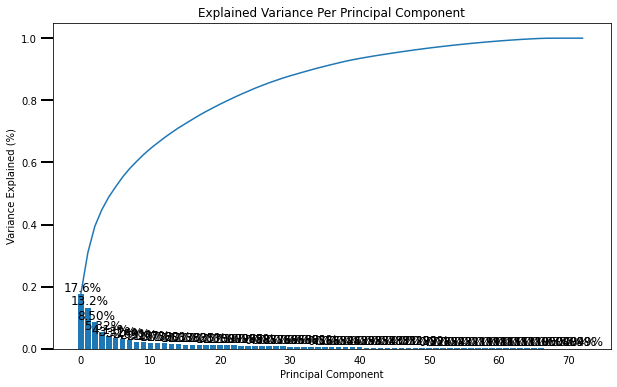

In [106]:
# Investigate the variance accounted for by each principal component for general population
scree_plot(pca_gen)

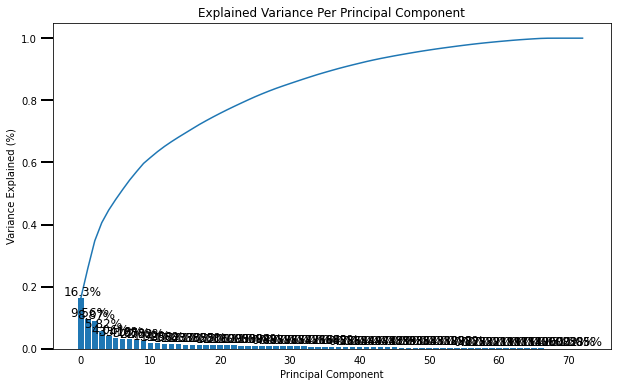

In [107]:
# Investigate the variance accounted for by each principal component for customers
scree_plot(pca_cus)

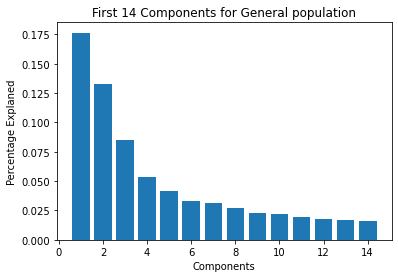

In [108]:
#explore most important components
plt.bar([gen_dict[key][0] for key in range(0,14)], [gen_dict[key][1] for key in range(0,14)])
plt.title('First 14 Components for General population')
plt.xlabel('Components')
plt.ylabel('Percentage Explaned');

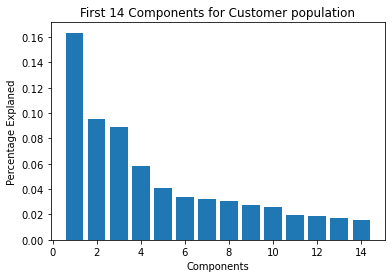

In [109]:
#explore most important components
plt.bar([cus_dict[key][0] for key in range(0,14)], [cus_dict[key][1] for key in range(0,14)])
plt.title('First 14 Components for Customer population')
plt.xlabel('Components')
plt.ylabel('Percentage Explaned');

### Discussion 2.2: Perform Dimensionality Reduction

- Initially we applied PRINCIPAL COMPONENT ANALYSIS in the entire dataset of 73 features to check the percentage of variance explained by the model. 
- We identified 14 Components that explain almost 70% of the variance of the model.Each of the rest of the features explain less than 0.15 % of the model almost equally so we decided to remove them as the have very small significnce in the overall process.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [110]:
#create a list of General population components to uncover their identity significance in the dataset
gen_comps = [list(pca_gen.components_[i]) for i in range(0,73)]

In [111]:
#create a list of Customer components to uncover their identity significance in the dataset
cus_comps = [list(pca_cus.components_[i]) for i in range(0,73)]

In [112]:
#map General population components list of lists into a pandas DataFrame
g_comp = pd.DataFrame.from_dict(dict(zip(gen_scaled.columns, gen_comps)), orient='index')

In [113]:
#map General population components list of lists into a pandas DataFrame
c_comp = pd.DataFrame.from_dict(dict(zip(cus_scaled.columns, cus_comps)), orient='index')

In [114]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
g_comp[0].sort_values(ascending = False).head(14)    

ARBEIT                 0.645964
O                      0.376051
ANREDE_KZ              0.256685
ORTSGR_KLS9            0.220070
PLZ8_ANTG3             0.179185
LP_LEBENSPHASE_FEIN    0.144256
PLZ8_HHZ               0.144162
WOHNLAGE               0.128713
MOBI_REGIO             0.119528
SEMIO_SOZ              0.110797
KKK                    0.103922
SEMIO_FAM              0.098043
WOHNDAUER_2008         0.092850
SEMIO_DOM              0.088790
Name: 0, dtype: float64

In [115]:
c_comp[0].sort_values(ascending = False).head(14) 

FINANZ_HAUSBAUER         0.253223
FINANZ_VORSORGER         0.165526
MOBI_REGIO               0.156829
O                        0.138732
ALTER_HH                 0.102917
RETOURTYP_BK_S           0.101686
INNENSTADT               0.090264
SEMIO_SOZ                0.080203
PRAEGENDE_JUGENDJAHRE    0.077517
FINANZ_ANLEGER           0.058734
ONLINE_AFFINITAET        0.050950
SEMIO_RAT                0.049690
KBA05_ANTG3              0.048024
ANZ_HAUSHALTE_AKTIV      0.043966
Name: 0, dtype: float64

In [116]:
#Define function to uncover the identity of principal components
def uncover_component(df, pc):
    '''A function to identify principal components
    First Principal component is 0, second 1, third 2 etc
    INPUT:(df) A dataframe keeping PrincipalmComponents in Columns and Variable names in index
          (pc) The pricipal component name we want to uncover. The first principal starts from 0'''
    principal = list(df[pc].sort_values(ascending = False).head(1).index)[0]
    print('Principal component {} is {}'.format((pc + 1), principal))
    return principal
    

In [117]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
g_comp[1].sort_values(ascending = False).head(1).index

Index(['O'], dtype='object')

In [118]:
c_comp[1].sort_values(ascending = False).head(14)   

O                        0.827588
PLZ8_ANTG3               0.146310
FINANZ_SPARER            0.130402
ALTERSKATEGORIE_GROB     0.112196
PLZ8_ANTG2               0.092956
PLZ8_ANTG4               0.089338
KBA05_GBZ                0.082504
KBA05_ANTG4              0.070678
FINANZ_UNAUFFAELLIGER    0.069476
ANREDE_KZ                0.060026
KBA05_ANTG1              0.053274
W_KEIT_KIND_HH           0.045456
SEMIO_KRIT               0.044951
SEMIO_DOM                0.044717
Name: 1, dtype: float64

In [119]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
g_comp[2].sort_values(ascending = False).head(14) 

PLZ8_HHZ              0.539631
KBA13_ANZAHL_PKW      0.240609
RELAT_AB              0.156875
HH_EINKOMMEN_SCORE    0.155443
FINANZ_MINIMALIST     0.153447
ONLINE_AFFINITAET     0.134732
SEMIO_MAT             0.122385
PLZ8_ANTG3            0.105485
ANREDE_KZ             0.086512
SEMIO_FAM             0.075034
INNENSTADT            0.071164
SOHO_KZ               0.063731
SEMIO_SOZ             0.061312
SEMIO_DOM             0.060624
Name: 2, dtype: float64

In [120]:
g_comp[2].sort_values(ascending = False).head(14) 

PLZ8_HHZ              0.539631
KBA13_ANZAHL_PKW      0.240609
RELAT_AB              0.156875
HH_EINKOMMEN_SCORE    0.155443
FINANZ_MINIMALIST     0.153447
ONLINE_AFFINITAET     0.134732
SEMIO_MAT             0.122385
PLZ8_ANTG3            0.105485
ANREDE_KZ             0.086512
SEMIO_FAM             0.075034
INNENSTADT            0.071164
SOHO_KZ               0.063731
SEMIO_SOZ             0.061312
SEMIO_DOM             0.060624
Name: 2, dtype: float64

In [121]:
#get first 14 principal components in the general population
g_principal_list = []
for i in range(0,14):
    principal = uncover_component(g_comp, i)
    g_principal_list.append(principal)

Principal component 1 is ARBEIT
Principal component 2 is O
Principal component 3 is PLZ8_HHZ
Principal component 4 is MOBI_REGIO
Principal component 5 is KBA13_ANZAHL_PKW
Principal component 6 is KBA05_ANTG1
Principal component 7 is MIN_GEBAEUDEJAHR
Principal component 8 is PLZ8_HHZ
Principal component 9 is nucleo
Principal component 10 is VERS_TYP
Principal component 11 is FINANZ_VORSORGER
Principal component 12 is W
Principal component 13 is decades
Principal component 14 is SEMIO_KAEM


In [122]:
g_principal_list

['ARBEIT',
 'O',
 'PLZ8_HHZ',
 'MOBI_REGIO',
 'KBA13_ANZAHL_PKW',
 'KBA05_ANTG1',
 'MIN_GEBAEUDEJAHR',
 'PLZ8_HHZ',
 'nucleo',
 'VERS_TYP',
 'FINANZ_VORSORGER',
 'W',
 'decades',
 'SEMIO_KAEM']

In [123]:
[uncover_component(g_comp, i) for i in range(0,14)]

Principal component 1 is ARBEIT
Principal component 2 is O
Principal component 3 is PLZ8_HHZ
Principal component 4 is MOBI_REGIO
Principal component 5 is KBA13_ANZAHL_PKW
Principal component 6 is KBA05_ANTG1
Principal component 7 is MIN_GEBAEUDEJAHR
Principal component 8 is PLZ8_HHZ
Principal component 9 is nucleo
Principal component 10 is VERS_TYP
Principal component 11 is FINANZ_VORSORGER
Principal component 12 is W
Principal component 13 is decades
Principal component 14 is SEMIO_KAEM


['ARBEIT',
 'O',
 'PLZ8_HHZ',
 'MOBI_REGIO',
 'KBA13_ANZAHL_PKW',
 'KBA05_ANTG1',
 'MIN_GEBAEUDEJAHR',
 'PLZ8_HHZ',
 'nucleo',
 'VERS_TYP',
 'FINANZ_VORSORGER',
 'W',
 'decades',
 'SEMIO_KAEM']

In [124]:
#get first 14 principal components in the general population
c_principal_list = []
for i in range(0,14):
    principal = uncover_component(c_comp, i)
    c_principal_list.append(principal)

Principal component 1 is FINANZ_HAUSBAUER
Principal component 2 is O
Principal component 3 is PLZ8_HHZ
Principal component 4 is ARBEIT
Principal component 5 is ARBEIT
Principal component 6 is ANZ_HAUSHALTE_AKTIV
Principal component 7 is ANZ_TITEL
Principal component 8 is PLZ8_HHZ
Principal component 9 is nucleo
Principal component 10 is PRAEGENDE_JUGENDJAHRE
Principal component 11 is W
Principal component 12 is FINANZ_VORSORGER
Principal component 13 is ANREDE_KZ
Principal component 14 is SEMIO_MAT


In [125]:
g_principal_list

['ARBEIT',
 'O',
 'PLZ8_HHZ',
 'MOBI_REGIO',
 'KBA13_ANZAHL_PKW',
 'KBA05_ANTG1',
 'MIN_GEBAEUDEJAHR',
 'PLZ8_HHZ',
 'nucleo',
 'VERS_TYP',
 'FINANZ_VORSORGER',
 'W',
 'decades',
 'SEMIO_KAEM']

In [126]:
[uncover_component(c_comp, i) for i in range(0,14)]

Principal component 1 is FINANZ_HAUSBAUER
Principal component 2 is O
Principal component 3 is PLZ8_HHZ
Principal component 4 is ARBEIT
Principal component 5 is ARBEIT
Principal component 6 is ANZ_HAUSHALTE_AKTIV
Principal component 7 is ANZ_TITEL
Principal component 8 is PLZ8_HHZ
Principal component 9 is nucleo
Principal component 10 is PRAEGENDE_JUGENDJAHRE
Principal component 11 is W
Principal component 12 is FINANZ_VORSORGER
Principal component 13 is ANREDE_KZ
Principal component 14 is SEMIO_MAT


['FINANZ_HAUSBAUER',
 'O',
 'PLZ8_HHZ',
 'ARBEIT',
 'ARBEIT',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_TITEL',
 'PLZ8_HHZ',
 'nucleo',
 'PRAEGENDE_JUGENDJAHRE',
 'W',
 'FINANZ_VORSORGER',
 'ANREDE_KZ',
 'SEMIO_MAT']

In [127]:
pca14_gen, gen14_weights = do_pca(14, gen_scaled)

In [128]:
pca14_cus, cus14_weights = do_pca(14, cus_scaled)

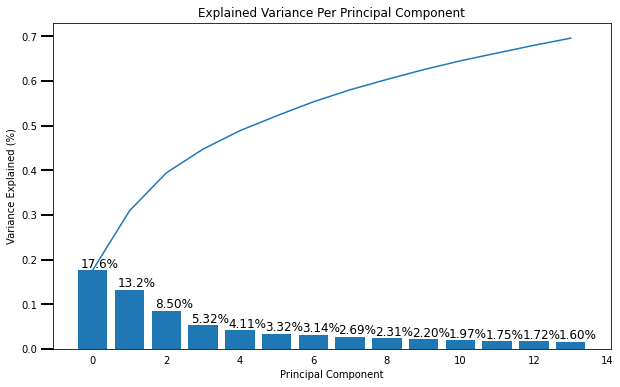

In [129]:
scree_plot(pca14_gen)

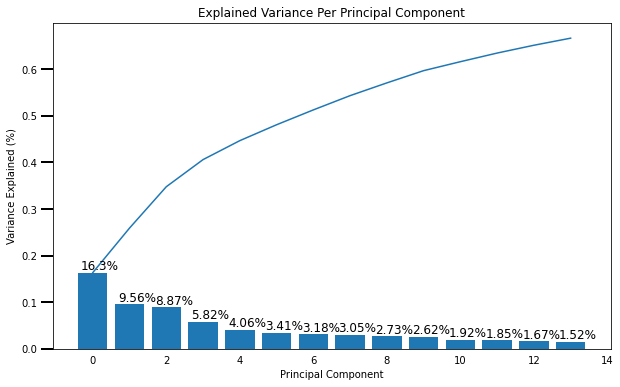

In [130]:
scree_plot(pca14_cus)

### Discussion 2.3: Interpret Principal Components

#### FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,
####     FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER

**General Popultion**

1. First Component Feature `FINANZ_HAUSBAUER`
Financial typology, for each dimension:
    - -1: unknown
    -  1: very high
    -  2: high
    -  3: average
    -  4: low
    -  5: very low

Dimension translations:
    - MINIMALIST: low financial interest
    - SPARER: money-saver
    - VORSORGER: be prepared
    - ANLEGER: investor
    - UNAUFFAELLIGER: inconspicuous
    - HAUSBAUER: home ownership
   
2. Second Component Feature
Ovest binary feature

3. Third component Feature `PLZ8_HHZ`
Number of households within the PLZ8 region
- -1: unknown
-  1: less than 130 households
-  2: 131-299 households
-  3: 300-599 households
-  4: 600-849 households
-  5: more than 849 households


**Customers Popultion**

1. First Component Feature `ARBEIT`

Share of unemployment in community
    - -1: unknown
    -  1: very low
    -  2: low
    -  3: average
    -  4: high
    -  5: very high
    -  9: unknown

2. Second Component Feature
Ovest binary feature



3. Third component Feature `PLZ8_HHZ`
Number of households within the PLZ8 region
- -1: unknown
-  1: less than 130 households
-  2: 131-299 households
-  3: 300-599 households
-  4: 600-849 households
-  5: more than 849 households


(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

To use KMeans, you need to follow three steps:

**I.** Instantiate your model.

**II.** Fit your model to the data.

**III.** Predict the labels for the data.

In [131]:
g_principal_list

['ARBEIT',
 'O',
 'PLZ8_HHZ',
 'MOBI_REGIO',
 'KBA13_ANZAHL_PKW',
 'KBA05_ANTG1',
 'MIN_GEBAEUDEJAHR',
 'PLZ8_HHZ',
 'nucleo',
 'VERS_TYP',
 'FINANZ_VORSORGER',
 'W',
 'decades',
 'SEMIO_KAEM']

In [132]:
gen_clust = gen.loc[:,g_principal_list]
cus_clust = cus.loc[:,c_principal_list]

In [133]:
c_principal_list

['FINANZ_HAUSBAUER',
 'O',
 'PLZ8_HHZ',
 'ARBEIT',
 'ARBEIT',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_TITEL',
 'PLZ8_HHZ',
 'nucleo',
 'PRAEGENDE_JUGENDJAHRE',
 'W',
 'FINANZ_VORSORGER',
 'ANREDE_KZ',
 'SEMIO_MAT']

In [134]:
from sklearn.cluster import KMeans

In [135]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
kmeans_4 = KMeans(n_clusters=4) #instantiate model
model_4 = kmeans_4.fit(gen_scaled) #fit the model to general population selected data using kmeans_4
labels_4 = model_4.predict(gen_scaled) #predict labels using gen_model_4 on our dataset  
# compute the average within-cluster distances.
np.abs(model_4.score(gen_scaled))

36601121.14484533

In [136]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
gen_model_4 = kmeans_4.fit(gen_clust) #fit the model to general population selected data using kmeans_4
gen_labels_4 = gen_model_4.predict(gen_clust) #predict labels using gen_model_4 on our dataset  

In [137]:
# compute the average within-cluster distances.
cus_model_4 = kmeans_4.fit(cus_clust) #fit the model to general population selected data using kmeans_4
cus_labels_4 = cus_model_4.predict(cus_clust) #predict labels using gen_model_4 on our dataset

In [138]:
# A place for your work - create a scree plot - you will need to
# Fit a kmeans model with changing k from 1-10
# Obtain the score for each model (take the absolute value)
# Plot the score against k
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

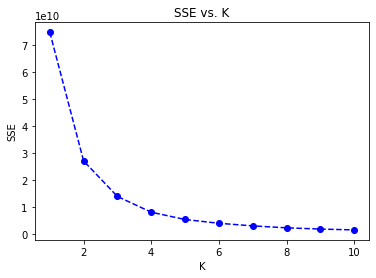

In [139]:
scores = []
centers = list(range(1,11))

for center in centers:
    scores.append(get_kmeans_score(gen_clust, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

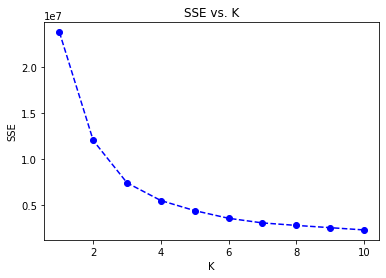

In [140]:
scores = []
centers = list(range(1,11))

for center in centers:
    scores.append(get_kmeans_score(cus_clust, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

### Discussion 3.1: Apply Clustering to General Population

It looks like if we insisted to get more than 4 clusters we get little improvement in our model. It looks like 4 clusters is the optimum solution for our data

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
print'Please see above'

In [ ]:
# Apply feature scaling to the customer data.
print'Please see above'

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
print'Please see above'

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [141]:
gen_dict = dict(zip(gen_clust.index, gen_labels_4))

In [142]:
gen_clust['cluster'] = gen_clust.index.map(gen_dict)

In [143]:
cus_dict = dict(zip(cus_clust.index, cus_labels_4))

In [144]:
cus_clust['cluster'] = cus_clust.index.map(cus_dict)

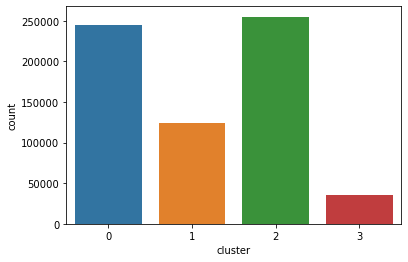

In [145]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.countplot(gen_clust['cluster']); #proportions in the general population

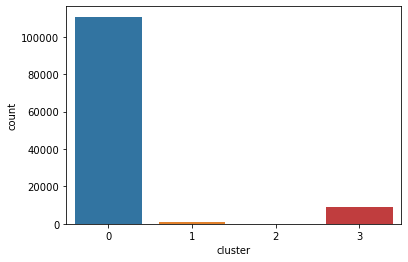

In [146]:
sns.countplot(cus_clust['cluster'])

In [147]:
gen_clust.columns

Index(['ARBEIT', 'O', 'PLZ8_HHZ', 'MOBI_REGIO', 'KBA13_ANZAHL_PKW',
       'KBA05_ANTG1', 'MIN_GEBAEUDEJAHR', 'PLZ8_HHZ', 'nucleo', 'VERS_TYP',
       'FINANZ_VORSORGER', 'W', 'decades', 'SEMIO_KAEM', 'cluster'],
      dtype='object')

In [148]:
cus_clust.columns

Index(['FINANZ_HAUSBAUER', 'O', 'PLZ8_HHZ', 'ARBEIT', 'ARBEIT',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_TITEL', 'PLZ8_HHZ', 'nucleo',
       'PRAEGENDE_JUGENDJAHRE', 'W', 'FINANZ_VORSORGER', 'ANREDE_KZ',
       'SEMIO_MAT', 'cluster'],
      dtype='object')

In [149]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cus_clust[cus_clust['cluster'] == 1].groupby('O').count()

,FINANZ_HAUSBAUER,PLZ8_HHZ,ARBEIT,ARBEIT,ANZ_HAUSHALTE_AKTIV,ANZ_TITEL,PLZ8_HHZ,nucleo,PRAEGENDE_JUGENDJAHRE,W,FINANZ_VORSORGER,ANREDE_KZ,SEMIO_MAT,cluster
O,,,,,,,,,,,,,,
0,794,794,794,794,794,794,794,794,794,794,794,794,794,794
1,133,133,133,133,133,133,133,133,133,133,133,133,133,133


In [150]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
gen_clust[gen_clust['cluster'] == 1].groupby('O').count()

,ARBEIT,PLZ8_HHZ,MOBI_REGIO,KBA13_ANZAHL_PKW,KBA05_ANTG1,MIN_GEBAEUDEJAHR,PLZ8_HHZ,nucleo,VERS_TYP,FINANZ_VORSORGER,W,decades,SEMIO_KAEM,cluster
O,,,,,,,,,,,,,,
0,107884,107884,107884,107884,107884,107884,107884,107884,107884,107884,107884,107884,107884,107884
1,16026,16026,16026,16026,16026,16026,16026,16026,16026,16026,16026,16026,16026,16026


In [151]:
gen_clust[gen_clust['cluster'] == 0].groupby('O').count()

,ARBEIT,PLZ8_HHZ,MOBI_REGIO,KBA13_ANZAHL_PKW,KBA05_ANTG1,MIN_GEBAEUDEJAHR,PLZ8_HHZ,nucleo,VERS_TYP,FINANZ_VORSORGER,W,decades,SEMIO_KAEM,cluster
O,,,,,,,,,,,,,,
0,164414,164414,164414,164414,164414,164414,164414,164414,164414,164414,164414,164414,164414,164414
1,80168,80168,80168,80168,80168,80168,80168,80168,80168,80168,80168,80168,80168,80168


In [152]:
cus_clust[gen_clust['cluster'] == 0].groupby('O').count()

<ipython-input-152-bf9d7f2ac37f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cus_clust[gen_clust['cluster'] == 0].groupby('O').count()


,FINANZ_HAUSBAUER,PLZ8_HHZ,ARBEIT,ARBEIT,ANZ_HAUSHALTE_AKTIV,ANZ_TITEL,PLZ8_HHZ,nucleo,PRAEGENDE_JUGENDJAHRE,W,FINANZ_VORSORGER,ANREDE_KZ,SEMIO_MAT,cluster
O,,,,,,,,,,,,,,
0,40848,40848,40848,40848,40848,40848,40848,40848,40848,40848,40848,40848,40848,40848
1,3466,3466,3466,3466,3466,3466,3466,3466,3466,3466,3466,3466,3466,3466


In [155]:
cus14_weights

array([[-3.65832306, -3.17969897,  0.98299622, ...,  0.00913371,
         0.95360474, -0.83216126],
       [ 3.61571824, -1.91863325, -2.79584848, ..., -2.25149264,
         0.55685614, -1.88444689],
       [ 2.22416252,  4.58304032,  2.15543459, ...,  0.89977666,
         1.2556945 , -1.8472521 ],
       ...,
       [-1.76965344, -2.52568415, -0.39326792, ..., -0.48137684,
        -1.00403086,  1.10710314],
       [ 2.17257498,  1.10337496, -3.05096541, ...,  1.82107099,
        -0.4421207 , -1.77409829],
       [-3.74513093,  1.50172537,  1.52517738, ...,  1.47518476,
        -1.70660781, -1.18243841]])

In [156]:
kmeans_4.cluster_centers_[1]

array([4.58683927e+00, 1.43473571e-01, 3.89967638e+00, 3.19741100e+00,
       3.19741100e+00, 8.61316073e+01, 2.15749730e-02, 3.89967638e+00,
       3.58036677e+00, 3.99029126e+00, 8.56526429e-01, 4.73894283e+00,
       1.51672060e+00, 3.38295577e+00])

In [157]:
kmeans_4.cluster_centers_[2]

array([4.56428571e+00, 1.35714286e-01, 4.24285714e+00, 3.10000000e+00,
       3.10000000e+00, 2.57600000e+02, 2.85714286e-02, 4.24285714e+00,
       4.42857143e+00, 3.06428571e+00, 8.64285714e-01, 4.86428571e+00,
       1.52857143e+00, 3.95000000e+00])

In [158]:
kmeans_4.cluster_centers_[3]

array([4.38305709e+00, 2.03986567e-01, 3.79633842e+00, 3.28458455e+00,
       3.28458455e+00, 2.10876395e+01, 1.67912469e-02, 3.79633842e+00,
       2.86112014e+00, 5.48337125e+00, 7.96013433e-01, 4.44383057e+00,
       1.46722999e+00, 3.42877261e+00])

In [160]:
kmeans_4.cluster_centers_[0]

array([2.59080476, 0.06835885, 3.61327779, 2.78051073, 2.78051073,
       2.33195381, 0.02210254, 3.61327779, 3.42952668, 5.69060958,
       0.93164115, 4.59760902, 1.30855909, 3.41358683])

In [161]:
kmeans_4.cluster_centers_

array([[2.59080476e+00, 6.83588455e-02, 3.61327779e+00, 2.78051073e+00,
        2.78051073e+00, 2.33195381e+00, 2.21025428e-02, 3.61327779e+00,
        3.42952668e+00, 5.69060958e+00, 9.31641154e-01, 4.59760902e+00,
        1.30855909e+00, 3.41358683e+00],
       [4.58683927e+00, 1.43473571e-01, 3.89967638e+00, 3.19741100e+00,
        3.19741100e+00, 8.61316073e+01, 2.15749730e-02, 3.89967638e+00,
        3.58036677e+00, 3.99029126e+00, 8.56526429e-01, 4.73894283e+00,
        1.51672060e+00, 3.38295577e+00],
       [4.56428571e+00, 1.35714286e-01, 4.24285714e+00, 3.10000000e+00,
        3.10000000e+00, 2.57600000e+02, 2.85714286e-02, 4.24285714e+00,
        4.42857143e+00, 3.06428571e+00, 8.64285714e-01, 4.86428571e+00,
        1.52857143e+00, 3.95000000e+00],
       [4.38305709e+00, 2.03986567e-01, 3.79633842e+00, 3.28458455e+00,
        3.28458455e+00, 2.10876395e+01, 1.67912469e-02, 3.79633842e+00,
        2.86112014e+00, 5.48337125e+00, 7.96013433e-01, 4.44383057e+00,
        1.467

In [163]:
#I get the entire dataset because the most important variables chosed by the pca in azdias are dieefent to customers
pca_gen, gen_weights = do_pca(73, gen_scaled)

In [165]:
pca_gen

PCA(copy=True, iterated_power='auto', n_components=73, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Since first 14 Principal Components are different in the general population and the customer population we will be using all 73 initial variables to compare how general population data fit in our customer's data

In [175]:
#gen_labels_4 keep cluster information for each element in our dataset. We calculated with Kmeans - Cluster Predictions
gen_labels_4

array([1, 2, 0, ..., 1, 0, 2])

In [176]:
#gen_weights keep information about the result of the pca - aka the importance of a variable
gen_weights

array([[ 3.88690257e+00, -3.00129240e+00, -2.75253081e+00, ...,
        -3.87196331e-14, -2.69442284e-15, -2.53543515e-14],
       [-8.43854661e-01, -4.54459616e-01, -3.32044963e+00, ...,
        -1.39843764e-14,  4.59594313e-15, -1.04871054e-15],
       [ 1.31282119e-01,  2.37140888e-01,  3.20157297e+00, ...,
        -2.38299060e-13,  8.30720333e-14, -1.95447521e-14],
       ...,
       [ 3.58023273e+00, -2.06571516e+00, -3.44151525e+00, ...,
         8.26230178e-17,  5.08821599e-17,  8.12593713e-17],
       [ 5.68771540e+00, -3.43387707e+00,  2.48497090e+00, ...,
        -2.35994614e-16, -4.24564281e-18, -9.36250924e-17],
       [-5.16169379e-01,  1.86660726e+00,  2.99512667e+00, ...,
         3.33295754e-16, -1.55961350e-16, -3.93870209e-17]])

In [182]:
#Here I see unique values of my clusters - How many people I have for each cluster
_, azdias_counts = np.unique(gen_labels_4, return_counts = True)

In [184]:
#here I calculate the percentage of people in each cluster in my dataset
azdias_counts/sum(azdias_counts)

array([0.3714376 , 0.18817751, 0.38719524, 0.05318965])

In [185]:
#I get the entire dataset because the most important variables chosed by the pca in azdias are dieefent to customers
pca_cus, cus_weights = do_pca(73, cus_scaled)

In [186]:
#the array of the predictions for the customer data calculated with kmeans - Cluster Predictions
cus_labels_4

array([0, 0, 0, ..., 0, 0, 0])

In [187]:
#cus_weights keep information about the result of the pca - aka the importance of a variable
cus_weights

array([[-3.65830942e+00, -3.17973364e+00,  9.82921792e-01, ...,
        -1.72843589e-14,  2.84496175e-15,  1.79519740e-15],
       [ 3.61572548e+00, -1.91870116e+00, -2.79612683e+00, ...,
         1.91052265e-14, -3.12456461e-15, -1.52795305e-15],
       [ 2.22414702e+00,  4.58308782e+00,  2.15547191e+00, ...,
        -3.82828813e-14,  5.12099422e-15,  4.33030081e-15],
       ...,
       [-1.76965451e+00, -2.52568762e+00, -3.93298385e-01, ...,
        -5.04177083e-17,  3.65737168e-18,  6.13422235e-20],
       [ 2.17257270e+00,  1.10330409e+00, -3.05111633e+00, ...,
         1.47762683e-15, -2.46624699e-16, -1.77308959e-16],
       [-3.74512218e+00,  1.50168650e+00,  1.52519924e+00, ...,
        -5.42815138e-16,  6.08448271e-17,  5.82547024e-17]])

In [188]:
#Here I see unique values of my clusters - How many people I have for each cluster
_, cust_counts = np.unique(cus_labels_4, return_counts = True)

In [189]:
#here I calculate the percentage of people in each cluster in my dataset
azdias_counts/sum(azdias_counts)

array([0.3714376 , 0.18817751, 0.38719524, 0.05318965])

In [196]:
#check first component for General population
uncover_component(g_comp, 0)

Principal component 1 is ARBEIT


'ARBEIT'

In [197]:
#check first component for customer population
uncover_component(c_comp, 0)

Principal component 1 is FINANZ_HAUSBAUER


'FINANZ_HAUSBAUER'

In [201]:
#Most positive Features
g_comp[0].sort_values(ascending = False).head(14)

ARBEIT                 0.645964
O                      0.376051
ANREDE_KZ              0.256685
ORTSGR_KLS9            0.220070
PLZ8_ANTG3             0.179185
LP_LEBENSPHASE_FEIN    0.144256
PLZ8_HHZ               0.144162
WOHNLAGE               0.128713
MOBI_REGIO             0.119528
SEMIO_SOZ              0.110797
KKK                    0.103922
SEMIO_FAM              0.098043
WOHNDAUER_2008         0.092850
SEMIO_DOM              0.088790
Name: 0, dtype: float64

In [203]:
#Most negative Features
g_comp[0].sort_values(ascending = False).tail(14)

CAMEO_INTL_2015        -0.045424
BALLRAUM               -0.051791
VERS_TYP               -0.053500
SEMIO_MAT              -0.061321
SEMIO_KRIT             -0.062086
PLZ8_ANTG4             -0.067807
PLZ8_ANTG1             -0.072720
RELAT_AB               -0.076138
GREEN_AVANTGARDE       -0.081773
HEALTH_TYP             -0.092801
SEMIO_LUST             -0.102172
ALTERSKATEGORIE_GROB   -0.102757
KBA13_ANZAHL_PKW       -0.122567
PLZ8_GBZ               -0.230492
Name: 0, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

Although the specific categories for the customer and general population data are different for the first component, they both tell us that the most important piece of information to collect in order to create our clusters is the age of a certan person. The second most important aspect to concider is their Personality typology and the third most important thing to concider is Membership in environmental sustainability as part of youth

Distributions are quite different in different datasets:
Clusters 0, 1 and 2 are overerepresented in the Customer data and 3, 4 are underpresented in the Customer Data

I would suggest further investigation to define the age variable. While in both analyses we do have evidence of significance in the age variable, one dataset delivers `ALTERSKATEGORIE_GROB` variable while the other the `decade` variable. 


(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.